# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0k/60.0k [04:57<00:00, 366File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

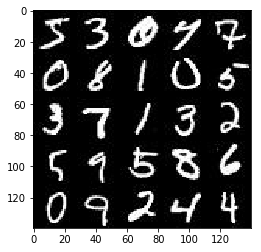

In [50]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

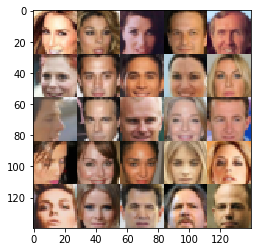

In [51]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1


E:\4th\DSNanoDegree\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [53]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(dtype=tf.float32, shape=[])
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        alpha = .2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = .2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        #print(x2.shape)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print(x3.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print(logits.shape)
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [61]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # Define Model_Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Define Model_Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    # Define Model_Opt
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    ### Training
    n_total_batches = data_shape[0] // batch_size
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_counter = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_counter += 1
                
                # Need to first scale real image values from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images*2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                              input_z: batch_z,
                                              lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                # For each 10 batches, get the losses and print them out
                
                if batch_counter % 10 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    g_train_loss = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{} - Batch {}/{}: ".format(epoch_i+1, epoch_count, batch_counter, n_total_batches),
                         "Discriminator loss = {:.4f} ".format(d_train_loss),
                         "Generator loss = {:.4f}".format(g_train_loss))
                    
                # Show generator output samples so we can see the progress during training
                
                if batch_counter % 100 == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 - Batch 10/1875:  Discriminator loss = 1.8944  Generator loss = 0.4035
Epoch 1/2 - Batch 20/1875:  Discriminator loss = 1.2252  Generator loss = 0.9951
Epoch 1/2 - Batch 30/1875:  Discriminator loss = 2.1315  Generator loss = 0.2532
Epoch 1/2 - Batch 40/1875:  Discriminator loss = 1.5322  Generator loss = 0.4861
Epoch 1/2 - Batch 50/1875:  Discriminator loss = 0.9025  Generator loss = 1.2798
Epoch 1/2 - Batch 60/1875:  Discriminator loss = 2.3353  Generator loss = 0.2869
Epoch 1/2 - Batch 70/1875:  Discriminator loss = 1.8698  Generator loss = 0.3932
Epoch 1/2 - Batch 80/1875:  Discriminator loss = 1.3298  Generator loss = 0.6427
Epoch 1/2 - Batch 90/1875:  Discriminator loss = 1.1484  Generator loss = 0.8692
Epoch 1/2 - Batch 100/1875:  Discriminator loss = 1.1432  Generator loss = 0.9461


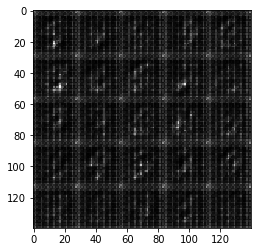

Epoch 1/2 - Batch 110/1875:  Discriminator loss = 1.6278  Generator loss = 1.3894
Epoch 1/2 - Batch 120/1875:  Discriminator loss = 1.3412  Generator loss = 1.3978
Epoch 1/2 - Batch 130/1875:  Discriminator loss = 1.2874  Generator loss = 0.7915
Epoch 1/2 - Batch 140/1875:  Discriminator loss = 1.2915  Generator loss = 1.2704
Epoch 1/2 - Batch 150/1875:  Discriminator loss = 1.0887  Generator loss = 1.1200
Epoch 1/2 - Batch 160/1875:  Discriminator loss = 0.9360  Generator loss = 1.2515
Epoch 1/2 - Batch 170/1875:  Discriminator loss = 1.3225  Generator loss = 1.0786
Epoch 1/2 - Batch 180/1875:  Discriminator loss = 1.3004  Generator loss = 0.6470
Epoch 1/2 - Batch 190/1875:  Discriminator loss = 1.0642  Generator loss = 1.6149
Epoch 1/2 - Batch 200/1875:  Discriminator loss = 1.3419  Generator loss = 0.5623


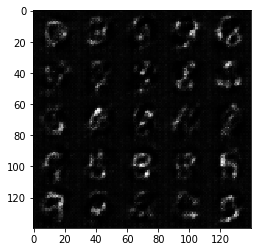

Epoch 1/2 - Batch 210/1875:  Discriminator loss = 1.1342  Generator loss = 1.7918
Epoch 1/2 - Batch 220/1875:  Discriminator loss = 0.8149  Generator loss = 1.3040
Epoch 1/2 - Batch 230/1875:  Discriminator loss = 0.9448  Generator loss = 1.3738
Epoch 1/2 - Batch 240/1875:  Discriminator loss = 1.2182  Generator loss = 0.6327
Epoch 1/2 - Batch 250/1875:  Discriminator loss = 1.0444  Generator loss = 0.9434
Epoch 1/2 - Batch 260/1875:  Discriminator loss = 0.7822  Generator loss = 1.6674
Epoch 1/2 - Batch 270/1875:  Discriminator loss = 0.9219  Generator loss = 1.8187
Epoch 1/2 - Batch 280/1875:  Discriminator loss = 0.9755  Generator loss = 1.5531
Epoch 1/2 - Batch 290/1875:  Discriminator loss = 1.2946  Generator loss = 0.6123
Epoch 1/2 - Batch 300/1875:  Discriminator loss = 1.1474  Generator loss = 0.8746


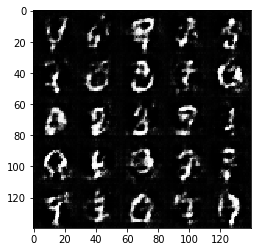

Epoch 1/2 - Batch 310/1875:  Discriminator loss = 1.0179  Generator loss = 0.9522
Epoch 1/2 - Batch 320/1875:  Discriminator loss = 1.0084  Generator loss = 0.9619
Epoch 1/2 - Batch 330/1875:  Discriminator loss = 1.6573  Generator loss = 0.4350
Epoch 1/2 - Batch 340/1875:  Discriminator loss = 1.2477  Generator loss = 0.6436
Epoch 1/2 - Batch 350/1875:  Discriminator loss = 1.1592  Generator loss = 0.7558
Epoch 1/2 - Batch 360/1875:  Discriminator loss = 0.8887  Generator loss = 1.2480
Epoch 1/2 - Batch 370/1875:  Discriminator loss = 1.4694  Generator loss = 0.4813
Epoch 1/2 - Batch 380/1875:  Discriminator loss = 1.0640  Generator loss = 1.1104
Epoch 1/2 - Batch 390/1875:  Discriminator loss = 0.8369  Generator loss = 1.6676
Epoch 1/2 - Batch 400/1875:  Discriminator loss = 1.3442  Generator loss = 0.5824


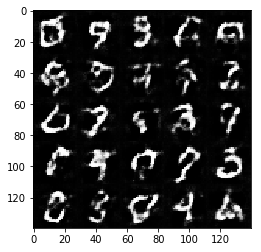

Epoch 1/2 - Batch 410/1875:  Discriminator loss = 1.9160  Generator loss = 0.3132
Epoch 1/2 - Batch 420/1875:  Discriminator loss = 1.0631  Generator loss = 0.8779
Epoch 1/2 - Batch 430/1875:  Discriminator loss = 1.1018  Generator loss = 1.2848
Epoch 1/2 - Batch 440/1875:  Discriminator loss = 1.0981  Generator loss = 1.2449
Epoch 1/2 - Batch 450/1875:  Discriminator loss = 0.9280  Generator loss = 1.0032
Epoch 1/2 - Batch 460/1875:  Discriminator loss = 1.0017  Generator loss = 1.5779
Epoch 1/2 - Batch 470/1875:  Discriminator loss = 0.9872  Generator loss = 1.0706
Epoch 1/2 - Batch 480/1875:  Discriminator loss = 0.9555  Generator loss = 1.3437
Epoch 1/2 - Batch 490/1875:  Discriminator loss = 1.2416  Generator loss = 1.6544
Epoch 1/2 - Batch 500/1875:  Discriminator loss = 0.9576  Generator loss = 1.4675


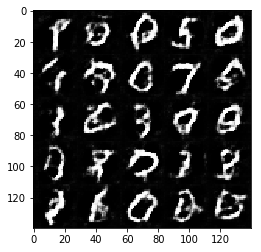

Epoch 1/2 - Batch 510/1875:  Discriminator loss = 1.1525  Generator loss = 0.7574
Epoch 1/2 - Batch 520/1875:  Discriminator loss = 0.9584  Generator loss = 1.8142
Epoch 1/2 - Batch 530/1875:  Discriminator loss = 1.0144  Generator loss = 0.9169
Epoch 1/2 - Batch 540/1875:  Discriminator loss = 1.8789  Generator loss = 0.3716
Epoch 1/2 - Batch 550/1875:  Discriminator loss = 0.9156  Generator loss = 1.2542
Epoch 1/2 - Batch 560/1875:  Discriminator loss = 0.9858  Generator loss = 1.3473
Epoch 1/2 - Batch 570/1875:  Discriminator loss = 0.9227  Generator loss = 1.4718
Epoch 1/2 - Batch 580/1875:  Discriminator loss = 1.0625  Generator loss = 1.6779
Epoch 1/2 - Batch 590/1875:  Discriminator loss = 0.9675  Generator loss = 0.8659
Epoch 1/2 - Batch 600/1875:  Discriminator loss = 1.1482  Generator loss = 0.9400


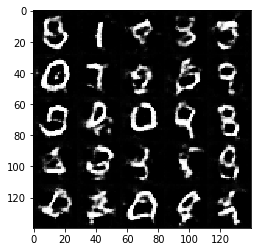

Epoch 1/2 - Batch 610/1875:  Discriminator loss = 0.9489  Generator loss = 1.1135
Epoch 1/2 - Batch 620/1875:  Discriminator loss = 1.2277  Generator loss = 0.6257
Epoch 1/2 - Batch 630/1875:  Discriminator loss = 0.9666  Generator loss = 1.3333
Epoch 1/2 - Batch 640/1875:  Discriminator loss = 1.6979  Generator loss = 0.3683
Epoch 1/2 - Batch 650/1875:  Discriminator loss = 2.4804  Generator loss = 0.1743
Epoch 1/2 - Batch 660/1875:  Discriminator loss = 0.9007  Generator loss = 1.2357
Epoch 1/2 - Batch 670/1875:  Discriminator loss = 1.5322  Generator loss = 2.3298
Epoch 1/2 - Batch 680/1875:  Discriminator loss = 1.0238  Generator loss = 1.4292
Epoch 1/2 - Batch 690/1875:  Discriminator loss = 1.2214  Generator loss = 0.6624
Epoch 1/2 - Batch 700/1875:  Discriminator loss = 0.6585  Generator loss = 1.8608


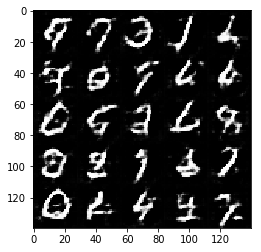

Epoch 1/2 - Batch 710/1875:  Discriminator loss = 1.9106  Generator loss = 0.2889
Epoch 1/2 - Batch 720/1875:  Discriminator loss = 1.0819  Generator loss = 0.7465
Epoch 1/2 - Batch 730/1875:  Discriminator loss = 0.9164  Generator loss = 1.1508
Epoch 1/2 - Batch 740/1875:  Discriminator loss = 0.8979  Generator loss = 0.9918
Epoch 1/2 - Batch 750/1875:  Discriminator loss = 0.9757  Generator loss = 1.8358
Epoch 1/2 - Batch 760/1875:  Discriminator loss = 0.7520  Generator loss = 1.2599
Epoch 1/2 - Batch 770/1875:  Discriminator loss = 1.2988  Generator loss = 0.7557
Epoch 1/2 - Batch 780/1875:  Discriminator loss = 1.0888  Generator loss = 1.6960
Epoch 1/2 - Batch 790/1875:  Discriminator loss = 1.5435  Generator loss = 0.4716
Epoch 1/2 - Batch 800/1875:  Discriminator loss = 1.7640  Generator loss = 0.3833


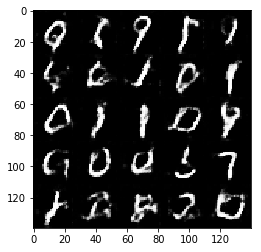

Epoch 1/2 - Batch 810/1875:  Discriminator loss = 0.9243  Generator loss = 1.7851
Epoch 1/2 - Batch 820/1875:  Discriminator loss = 1.3149  Generator loss = 0.5921
Epoch 1/2 - Batch 830/1875:  Discriminator loss = 0.9141  Generator loss = 1.1560
Epoch 1/2 - Batch 840/1875:  Discriminator loss = 1.1306  Generator loss = 2.3270
Epoch 1/2 - Batch 850/1875:  Discriminator loss = 1.2012  Generator loss = 0.6676
Epoch 1/2 - Batch 860/1875:  Discriminator loss = 1.0810  Generator loss = 0.8708
Epoch 1/2 - Batch 870/1875:  Discriminator loss = 1.2008  Generator loss = 0.6830
Epoch 1/2 - Batch 880/1875:  Discriminator loss = 1.2765  Generator loss = 0.5802
Epoch 1/2 - Batch 890/1875:  Discriminator loss = 1.2361  Generator loss = 0.6370
Epoch 1/2 - Batch 900/1875:  Discriminator loss = 0.8608  Generator loss = 1.0700


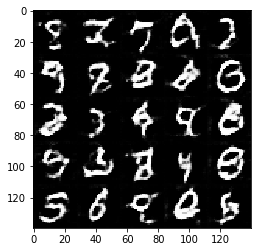

Epoch 1/2 - Batch 910/1875:  Discriminator loss = 0.7958  Generator loss = 2.0722
Epoch 1/2 - Batch 920/1875:  Discriminator loss = 1.2132  Generator loss = 0.6821
Epoch 1/2 - Batch 930/1875:  Discriminator loss = 1.4456  Generator loss = 0.5295
Epoch 1/2 - Batch 940/1875:  Discriminator loss = 0.9501  Generator loss = 1.0119
Epoch 1/2 - Batch 950/1875:  Discriminator loss = 0.8644  Generator loss = 1.6064
Epoch 1/2 - Batch 960/1875:  Discriminator loss = 1.3104  Generator loss = 0.5534
Epoch 1/2 - Batch 970/1875:  Discriminator loss = 1.1042  Generator loss = 0.6982
Epoch 1/2 - Batch 980/1875:  Discriminator loss = 0.7273  Generator loss = 2.2189
Epoch 1/2 - Batch 990/1875:  Discriminator loss = 1.1733  Generator loss = 0.6869
Epoch 1/2 - Batch 1000/1875:  Discriminator loss = 1.7372  Generator loss = 0.3808


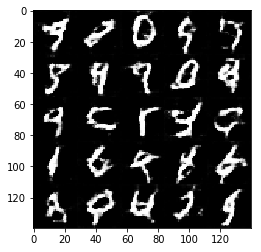

Epoch 1/2 - Batch 1010/1875:  Discriminator loss = 1.0848  Generator loss = 0.9116
Epoch 1/2 - Batch 1020/1875:  Discriminator loss = 0.8444  Generator loss = 1.3069
Epoch 1/2 - Batch 1030/1875:  Discriminator loss = 1.1801  Generator loss = 0.7814
Epoch 1/2 - Batch 1040/1875:  Discriminator loss = 1.1842  Generator loss = 0.8472
Epoch 1/2 - Batch 1050/1875:  Discriminator loss = 0.8808  Generator loss = 1.1465
Epoch 1/2 - Batch 1060/1875:  Discriminator loss = 1.1452  Generator loss = 0.8434
Epoch 1/2 - Batch 1070/1875:  Discriminator loss = 0.9141  Generator loss = 1.0360
Epoch 1/2 - Batch 1080/1875:  Discriminator loss = 1.0769  Generator loss = 0.7762
Epoch 1/2 - Batch 1090/1875:  Discriminator loss = 1.1111  Generator loss = 0.7595
Epoch 1/2 - Batch 1100/1875:  Discriminator loss = 1.1068  Generator loss = 0.7193


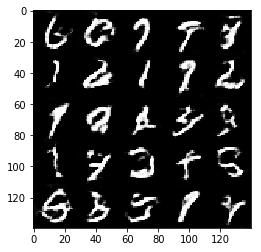

Epoch 1/2 - Batch 1110/1875:  Discriminator loss = 1.5199  Generator loss = 0.4607
Epoch 1/2 - Batch 1120/1875:  Discriminator loss = 1.3451  Generator loss = 0.5296
Epoch 1/2 - Batch 1130/1875:  Discriminator loss = 0.9390  Generator loss = 1.2691
Epoch 1/2 - Batch 1140/1875:  Discriminator loss = 1.3295  Generator loss = 0.7267
Epoch 1/2 - Batch 1150/1875:  Discriminator loss = 1.3447  Generator loss = 0.5883
Epoch 1/2 - Batch 1160/1875:  Discriminator loss = 0.9426  Generator loss = 0.9839
Epoch 1/2 - Batch 1170/1875:  Discriminator loss = 0.7506  Generator loss = 1.3748
Epoch 1/2 - Batch 1180/1875:  Discriminator loss = 1.1453  Generator loss = 0.6891
Epoch 1/2 - Batch 1190/1875:  Discriminator loss = 0.9057  Generator loss = 1.0294
Epoch 1/2 - Batch 1200/1875:  Discriminator loss = 1.1042  Generator loss = 0.7926


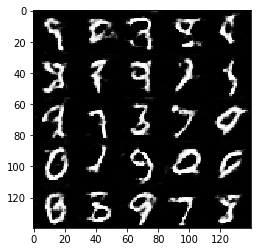

Epoch 1/2 - Batch 1210/1875:  Discriminator loss = 0.9149  Generator loss = 1.3152
Epoch 1/2 - Batch 1220/1875:  Discriminator loss = 0.9681  Generator loss = 1.1944
Epoch 1/2 - Batch 1230/1875:  Discriminator loss = 0.9843  Generator loss = 1.0678
Epoch 1/2 - Batch 1240/1875:  Discriminator loss = 0.9091  Generator loss = 1.0264
Epoch 1/2 - Batch 1250/1875:  Discriminator loss = 0.9589  Generator loss = 1.1060
Epoch 1/2 - Batch 1260/1875:  Discriminator loss = 0.8072  Generator loss = 1.1695
Epoch 1/2 - Batch 1270/1875:  Discriminator loss = 0.9103  Generator loss = 0.9728
Epoch 1/2 - Batch 1280/1875:  Discriminator loss = 0.7183  Generator loss = 1.3442
Epoch 1/2 - Batch 1290/1875:  Discriminator loss = 0.8197  Generator loss = 1.2843
Epoch 1/2 - Batch 1300/1875:  Discriminator loss = 1.1622  Generator loss = 2.4843


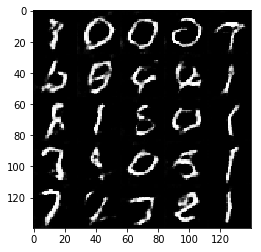

Epoch 1/2 - Batch 1310/1875:  Discriminator loss = 0.8797  Generator loss = 1.6587
Epoch 1/2 - Batch 1320/1875:  Discriminator loss = 1.3389  Generator loss = 1.2340
Epoch 1/2 - Batch 1330/1875:  Discriminator loss = 1.3000  Generator loss = 0.6176
Epoch 1/2 - Batch 1340/1875:  Discriminator loss = 0.9771  Generator loss = 2.0988
Epoch 1/2 - Batch 1350/1875:  Discriminator loss = 1.4012  Generator loss = 0.5362
Epoch 1/2 - Batch 1360/1875:  Discriminator loss = 1.2362  Generator loss = 0.6818
Epoch 1/2 - Batch 1370/1875:  Discriminator loss = 0.9722  Generator loss = 1.0520
Epoch 1/2 - Batch 1380/1875:  Discriminator loss = 0.9785  Generator loss = 1.6124
Epoch 1/2 - Batch 1390/1875:  Discriminator loss = 0.8412  Generator loss = 1.2826
Epoch 1/2 - Batch 1400/1875:  Discriminator loss = 1.2068  Generator loss = 0.6473


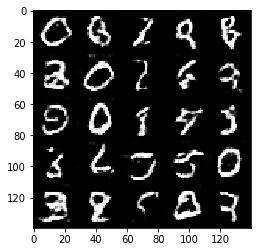

Epoch 1/2 - Batch 1410/1875:  Discriminator loss = 0.8920  Generator loss = 1.0846
Epoch 1/2 - Batch 1420/1875:  Discriminator loss = 0.9165  Generator loss = 0.9756
Epoch 1/2 - Batch 1430/1875:  Discriminator loss = 1.4193  Generator loss = 2.5751
Epoch 1/2 - Batch 1440/1875:  Discriminator loss = 1.0961  Generator loss = 0.8142
Epoch 1/2 - Batch 1450/1875:  Discriminator loss = 0.9219  Generator loss = 1.1875
Epoch 1/2 - Batch 1460/1875:  Discriminator loss = 0.7450  Generator loss = 1.3639
Epoch 1/2 - Batch 1470/1875:  Discriminator loss = 0.7283  Generator loss = 1.6471
Epoch 1/2 - Batch 1480/1875:  Discriminator loss = 0.8723  Generator loss = 2.3758
Epoch 1/2 - Batch 1490/1875:  Discriminator loss = 0.8783  Generator loss = 2.3551
Epoch 1/2 - Batch 1500/1875:  Discriminator loss = 1.4353  Generator loss = 0.5172


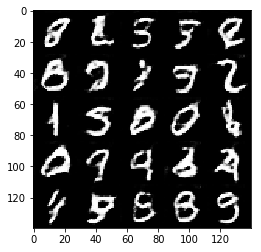

Epoch 1/2 - Batch 1510/1875:  Discriminator loss = 1.8885  Generator loss = 0.2855
Epoch 1/2 - Batch 1520/1875:  Discriminator loss = 0.9056  Generator loss = 1.0721
Epoch 1/2 - Batch 1530/1875:  Discriminator loss = 1.2226  Generator loss = 0.6903
Epoch 1/2 - Batch 1540/1875:  Discriminator loss = 0.7744  Generator loss = 1.3599
Epoch 1/2 - Batch 1550/1875:  Discriminator loss = 0.8977  Generator loss = 1.0499
Epoch 1/2 - Batch 1560/1875:  Discriminator loss = 1.0958  Generator loss = 0.7647
Epoch 1/2 - Batch 1570/1875:  Discriminator loss = 0.9431  Generator loss = 1.1814
Epoch 1/2 - Batch 1580/1875:  Discriminator loss = 4.5299  Generator loss = 6.3382
Epoch 1/2 - Batch 1590/1875:  Discriminator loss = 0.9769  Generator loss = 1.1022
Epoch 1/2 - Batch 1600/1875:  Discriminator loss = 1.5120  Generator loss = 0.4684


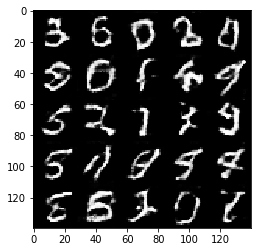

Epoch 1/2 - Batch 1610/1875:  Discriminator loss = 1.0088  Generator loss = 1.0554
Epoch 1/2 - Batch 1620/1875:  Discriminator loss = 0.9346  Generator loss = 1.0928
Epoch 1/2 - Batch 1630/1875:  Discriminator loss = 1.0894  Generator loss = 0.8738
Epoch 1/2 - Batch 1640/1875:  Discriminator loss = 0.9179  Generator loss = 0.9890
Epoch 1/2 - Batch 1650/1875:  Discriminator loss = 1.0207  Generator loss = 0.8491
Epoch 1/2 - Batch 1660/1875:  Discriminator loss = 0.9073  Generator loss = 1.0101
Epoch 1/2 - Batch 1670/1875:  Discriminator loss = 1.1945  Generator loss = 0.6522
Epoch 1/2 - Batch 1680/1875:  Discriminator loss = 0.9309  Generator loss = 1.0066
Epoch 1/2 - Batch 1690/1875:  Discriminator loss = 1.7787  Generator loss = 3.9667
Epoch 1/2 - Batch 1700/1875:  Discriminator loss = 1.0011  Generator loss = 0.9917


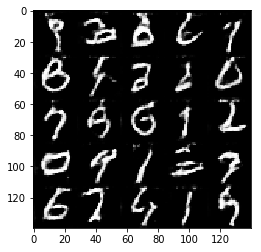

Epoch 1/2 - Batch 1710/1875:  Discriminator loss = 0.8843  Generator loss = 1.1843
Epoch 1/2 - Batch 1720/1875:  Discriminator loss = 1.2044  Generator loss = 1.7878
Epoch 1/2 - Batch 1730/1875:  Discriminator loss = 1.3056  Generator loss = 0.7417
Epoch 1/2 - Batch 1740/1875:  Discriminator loss = 0.8150  Generator loss = 1.4784
Epoch 1/2 - Batch 1750/1875:  Discriminator loss = 1.0938  Generator loss = 0.7555
Epoch 1/2 - Batch 1760/1875:  Discriminator loss = 1.4866  Generator loss = 0.5006
Epoch 1/2 - Batch 1770/1875:  Discriminator loss = 1.1098  Generator loss = 0.8660
Epoch 1/2 - Batch 1780/1875:  Discriminator loss = 0.6127  Generator loss = 1.7912
Epoch 1/2 - Batch 1790/1875:  Discriminator loss = 0.7140  Generator loss = 1.6919
Epoch 1/2 - Batch 1800/1875:  Discriminator loss = 0.7534  Generator loss = 2.8444


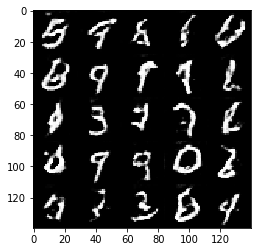

Epoch 1/2 - Batch 1810/1875:  Discriminator loss = 0.7610  Generator loss = 2.0503
Epoch 1/2 - Batch 1820/1875:  Discriminator loss = 1.0065  Generator loss = 0.8521
Epoch 1/2 - Batch 1830/1875:  Discriminator loss = 1.9277  Generator loss = 3.6226
Epoch 1/2 - Batch 1840/1875:  Discriminator loss = 0.8591  Generator loss = 1.3995
Epoch 1/2 - Batch 1850/1875:  Discriminator loss = 1.0091  Generator loss = 0.8765
Epoch 1/2 - Batch 1860/1875:  Discriminator loss = 1.4697  Generator loss = 0.4521
Epoch 1/2 - Batch 1870/1875:  Discriminator loss = 0.6955  Generator loss = 1.7446
Epoch 2/2 - Batch 10/1875:  Discriminator loss = 1.4697  Generator loss = 0.4957
Epoch 2/2 - Batch 20/1875:  Discriminator loss = 0.8756  Generator loss = 1.1232
Epoch 2/2 - Batch 30/1875:  Discriminator loss = 0.9567  Generator loss = 0.8942
Epoch 2/2 - Batch 40/1875:  Discriminator loss = 1.0398  Generator loss = 2.3742
Epoch 2/2 - Batch 50/1875:  Discriminator loss = 0.9685  Generator loss = 0.9168
Epoch 2/2 - Ba

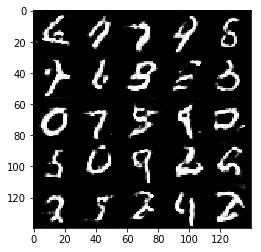

Epoch 2/2 - Batch 110/1875:  Discriminator loss = 1.2122  Generator loss = 0.6869
Epoch 2/2 - Batch 120/1875:  Discriminator loss = 0.8661  Generator loss = 1.2949
Epoch 2/2 - Batch 130/1875:  Discriminator loss = 1.3210  Generator loss = 0.6418
Epoch 2/2 - Batch 140/1875:  Discriminator loss = 1.0093  Generator loss = 0.9848
Epoch 2/2 - Batch 150/1875:  Discriminator loss = 0.9450  Generator loss = 0.9520
Epoch 2/2 - Batch 160/1875:  Discriminator loss = 0.7797  Generator loss = 2.0113
Epoch 2/2 - Batch 170/1875:  Discriminator loss = 1.2857  Generator loss = 0.6986
Epoch 2/2 - Batch 180/1875:  Discriminator loss = 1.1961  Generator loss = 0.6301
Epoch 2/2 - Batch 190/1875:  Discriminator loss = 0.8863  Generator loss = 1.0792
Epoch 2/2 - Batch 200/1875:  Discriminator loss = 1.0313  Generator loss = 0.8591


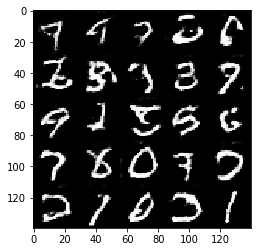

Epoch 2/2 - Batch 210/1875:  Discriminator loss = 1.1205  Generator loss = 0.9193
Epoch 2/2 - Batch 220/1875:  Discriminator loss = 0.7753  Generator loss = 2.3355
Epoch 2/2 - Batch 230/1875:  Discriminator loss = 0.8771  Generator loss = 2.0242
Epoch 2/2 - Batch 240/1875:  Discriminator loss = 0.8184  Generator loss = 1.2872
Epoch 2/2 - Batch 250/1875:  Discriminator loss = 0.8741  Generator loss = 1.0838
Epoch 2/2 - Batch 260/1875:  Discriminator loss = 0.7440  Generator loss = 1.8549
Epoch 2/2 - Batch 270/1875:  Discriminator loss = 0.7760  Generator loss = 1.2514
Epoch 2/2 - Batch 280/1875:  Discriminator loss = 0.7357  Generator loss = 1.6051
Epoch 2/2 - Batch 290/1875:  Discriminator loss = 1.6721  Generator loss = 0.3917
Epoch 2/2 - Batch 300/1875:  Discriminator loss = 0.8432  Generator loss = 1.4332


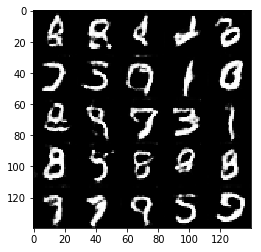

Epoch 2/2 - Batch 310/1875:  Discriminator loss = 0.6831  Generator loss = 1.6002
Epoch 2/2 - Batch 320/1875:  Discriminator loss = 1.4403  Generator loss = 0.4617
Epoch 2/2 - Batch 330/1875:  Discriminator loss = 1.0110  Generator loss = 0.9006
Epoch 2/2 - Batch 340/1875:  Discriminator loss = 1.0524  Generator loss = 0.9762
Epoch 2/2 - Batch 350/1875:  Discriminator loss = 1.3666  Generator loss = 0.5792
Epoch 2/2 - Batch 360/1875:  Discriminator loss = 0.7620  Generator loss = 1.4482
Epoch 2/2 - Batch 370/1875:  Discriminator loss = 1.1549  Generator loss = 0.7554
Epoch 2/2 - Batch 380/1875:  Discriminator loss = 0.9443  Generator loss = 1.0464
Epoch 2/2 - Batch 390/1875:  Discriminator loss = 0.7650  Generator loss = 1.2711
Epoch 2/2 - Batch 400/1875:  Discriminator loss = 0.9552  Generator loss = 0.9914


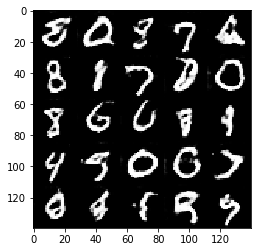

Epoch 2/2 - Batch 410/1875:  Discriminator loss = 0.8472  Generator loss = 1.1199
Epoch 2/2 - Batch 420/1875:  Discriminator loss = 0.7275  Generator loss = 1.4699
Epoch 2/2 - Batch 430/1875:  Discriminator loss = 0.7645  Generator loss = 1.2422
Epoch 2/2 - Batch 440/1875:  Discriminator loss = 1.1086  Generator loss = 0.8085
Epoch 2/2 - Batch 450/1875:  Discriminator loss = 0.8737  Generator loss = 1.2276
Epoch 2/2 - Batch 460/1875:  Discriminator loss = 1.0365  Generator loss = 0.7863
Epoch 2/2 - Batch 470/1875:  Discriminator loss = 0.9708  Generator loss = 0.8914
Epoch 2/2 - Batch 480/1875:  Discriminator loss = 0.7296  Generator loss = 1.4629
Epoch 2/2 - Batch 490/1875:  Discriminator loss = 0.7813  Generator loss = 1.2835
Epoch 2/2 - Batch 500/1875:  Discriminator loss = 0.8889  Generator loss = 1.0340


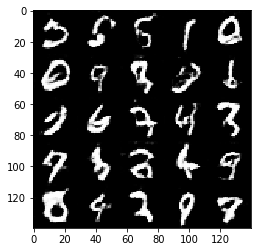

Epoch 2/2 - Batch 510/1875:  Discriminator loss = 1.1305  Generator loss = 3.6103
Epoch 2/2 - Batch 520/1875:  Discriminator loss = 0.8559  Generator loss = 1.9201
Epoch 2/2 - Batch 530/1875:  Discriminator loss = 1.0774  Generator loss = 0.9023
Epoch 2/2 - Batch 540/1875:  Discriminator loss = 1.0366  Generator loss = 0.9334
Epoch 2/2 - Batch 550/1875:  Discriminator loss = 0.7546  Generator loss = 2.2974
Epoch 2/2 - Batch 560/1875:  Discriminator loss = 0.9658  Generator loss = 1.0879
Epoch 2/2 - Batch 570/1875:  Discriminator loss = 0.7541  Generator loss = 1.2425
Epoch 2/2 - Batch 580/1875:  Discriminator loss = 0.7676  Generator loss = 1.2406
Epoch 2/2 - Batch 590/1875:  Discriminator loss = 0.6893  Generator loss = 1.4531
Epoch 2/2 - Batch 600/1875:  Discriminator loss = 1.0074  Generator loss = 0.9511


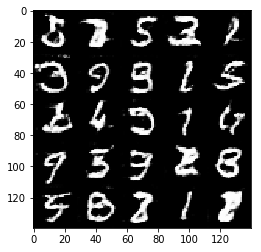

Epoch 2/2 - Batch 610/1875:  Discriminator loss = 0.9243  Generator loss = 1.7260
Epoch 2/2 - Batch 620/1875:  Discriminator loss = 1.3369  Generator loss = 0.5336
Epoch 2/2 - Batch 630/1875:  Discriminator loss = 0.9614  Generator loss = 2.3153
Epoch 2/2 - Batch 640/1875:  Discriminator loss = 0.9684  Generator loss = 1.4416
Epoch 2/2 - Batch 650/1875:  Discriminator loss = 0.7510  Generator loss = 1.2696
Epoch 2/2 - Batch 660/1875:  Discriminator loss = 0.6844  Generator loss = 1.4949
Epoch 2/2 - Batch 670/1875:  Discriminator loss = 1.1134  Generator loss = 0.7869
Epoch 2/2 - Batch 680/1875:  Discriminator loss = 1.2221  Generator loss = 0.7709
Epoch 2/2 - Batch 690/1875:  Discriminator loss = 1.0997  Generator loss = 0.7803
Epoch 2/2 - Batch 700/1875:  Discriminator loss = 0.8196  Generator loss = 1.1320


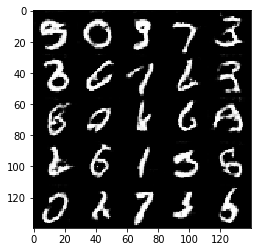

Epoch 2/2 - Batch 710/1875:  Discriminator loss = 0.7351  Generator loss = 1.4539
Epoch 2/2 - Batch 720/1875:  Discriminator loss = 0.7136  Generator loss = 1.3880
Epoch 2/2 - Batch 730/1875:  Discriminator loss = 0.8618  Generator loss = 1.0524
Epoch 2/2 - Batch 740/1875:  Discriminator loss = 0.6461  Generator loss = 1.8709
Epoch 2/2 - Batch 750/1875:  Discriminator loss = 0.9741  Generator loss = 2.4403
Epoch 2/2 - Batch 760/1875:  Discriminator loss = 0.6275  Generator loss = 1.7959
Epoch 2/2 - Batch 770/1875:  Discriminator loss = 0.7240  Generator loss = 2.1884
Epoch 2/2 - Batch 780/1875:  Discriminator loss = 0.8460  Generator loss = 1.1197
Epoch 2/2 - Batch 790/1875:  Discriminator loss = 0.6150  Generator loss = 2.1403
Epoch 2/2 - Batch 800/1875:  Discriminator loss = 1.4082  Generator loss = 0.5436


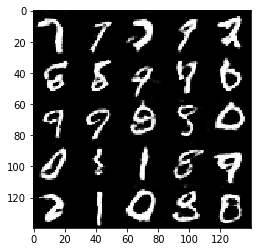

Epoch 2/2 - Batch 810/1875:  Discriminator loss = 0.6045  Generator loss = 3.1176
Epoch 2/2 - Batch 820/1875:  Discriminator loss = 1.2393  Generator loss = 0.7445
Epoch 2/2 - Batch 830/1875:  Discriminator loss = 1.3967  Generator loss = 0.6862
Epoch 2/2 - Batch 840/1875:  Discriminator loss = 0.6234  Generator loss = 1.9593
Epoch 2/2 - Batch 850/1875:  Discriminator loss = 0.7587  Generator loss = 1.9595
Epoch 2/2 - Batch 860/1875:  Discriminator loss = 0.7501  Generator loss = 1.5655
Epoch 2/2 - Batch 870/1875:  Discriminator loss = 1.3859  Generator loss = 0.5344
Epoch 2/2 - Batch 880/1875:  Discriminator loss = 1.6799  Generator loss = 0.3656
Epoch 2/2 - Batch 890/1875:  Discriminator loss = 0.8426  Generator loss = 1.1187
Epoch 2/2 - Batch 900/1875:  Discriminator loss = 0.8529  Generator loss = 1.0824


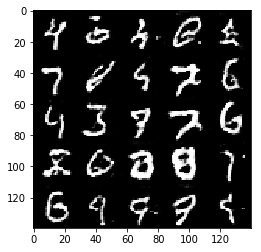

Epoch 2/2 - Batch 910/1875:  Discriminator loss = 1.0765  Generator loss = 0.8616
Epoch 2/2 - Batch 920/1875:  Discriminator loss = 0.6686  Generator loss = 1.4435
Epoch 2/2 - Batch 930/1875:  Discriminator loss = 1.6334  Generator loss = 3.3822
Epoch 2/2 - Batch 940/1875:  Discriminator loss = 1.1174  Generator loss = 0.8230
Epoch 2/2 - Batch 950/1875:  Discriminator loss = 1.4124  Generator loss = 0.5588
Epoch 2/2 - Batch 960/1875:  Discriminator loss = 0.7649  Generator loss = 1.4115
Epoch 2/2 - Batch 970/1875:  Discriminator loss = 0.8711  Generator loss = 1.0259
Epoch 2/2 - Batch 980/1875:  Discriminator loss = 0.9704  Generator loss = 3.2250
Epoch 2/2 - Batch 990/1875:  Discriminator loss = 1.0778  Generator loss = 0.8381
Epoch 2/2 - Batch 1000/1875:  Discriminator loss = 0.6308  Generator loss = 1.7880


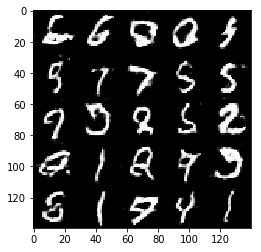

Epoch 2/2 - Batch 1010/1875:  Discriminator loss = 0.7880  Generator loss = 1.1963
Epoch 2/2 - Batch 1020/1875:  Discriminator loss = 1.3520  Generator loss = 0.5551
Epoch 2/2 - Batch 1030/1875:  Discriminator loss = 0.8935  Generator loss = 1.3020
Epoch 2/2 - Batch 1040/1875:  Discriminator loss = 0.7175  Generator loss = 1.4453
Epoch 2/2 - Batch 1050/1875:  Discriminator loss = 0.7248  Generator loss = 1.3479
Epoch 2/2 - Batch 1060/1875:  Discriminator loss = 0.8370  Generator loss = 1.1913
Epoch 2/2 - Batch 1070/1875:  Discriminator loss = 0.8211  Generator loss = 1.1693
Epoch 2/2 - Batch 1080/1875:  Discriminator loss = 0.9574  Generator loss = 1.0402
Epoch 2/2 - Batch 1090/1875:  Discriminator loss = 0.8671  Generator loss = 1.0808
Epoch 2/2 - Batch 1100/1875:  Discriminator loss = 1.1805  Generator loss = 0.8107


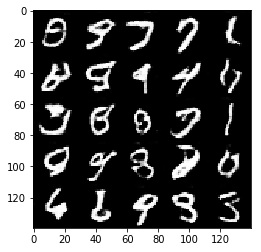

Epoch 2/2 - Batch 1110/1875:  Discriminator loss = 0.6013  Generator loss = 1.9820
Epoch 2/2 - Batch 1120/1875:  Discriminator loss = 0.6113  Generator loss = 2.0924
Epoch 2/2 - Batch 1130/1875:  Discriminator loss = 1.8376  Generator loss = 0.4438
Epoch 2/2 - Batch 1140/1875:  Discriminator loss = 0.8565  Generator loss = 1.1656
Epoch 2/2 - Batch 1150/1875:  Discriminator loss = 1.0920  Generator loss = 0.7688
Epoch 2/2 - Batch 1160/1875:  Discriminator loss = 0.6851  Generator loss = 1.5488
Epoch 2/2 - Batch 1170/1875:  Discriminator loss = 0.8698  Generator loss = 1.1183
Epoch 2/2 - Batch 1180/1875:  Discriminator loss = 1.0809  Generator loss = 0.7670
Epoch 2/2 - Batch 1190/1875:  Discriminator loss = 0.5370  Generator loss = 2.4010
Epoch 2/2 - Batch 1200/1875:  Discriminator loss = 1.0310  Generator loss = 0.8301


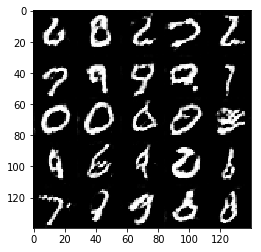

Epoch 2/2 - Batch 1210/1875:  Discriminator loss = 0.6869  Generator loss = 1.5431
Epoch 2/2 - Batch 1220/1875:  Discriminator loss = 1.4155  Generator loss = 4.3932
Epoch 2/2 - Batch 1230/1875:  Discriminator loss = 0.7155  Generator loss = 1.5481
Epoch 2/2 - Batch 1240/1875:  Discriminator loss = 0.5470  Generator loss = 2.0305
Epoch 2/2 - Batch 1250/1875:  Discriminator loss = 0.7137  Generator loss = 1.5756
Epoch 2/2 - Batch 1260/1875:  Discriminator loss = 0.6667  Generator loss = 1.5965
Epoch 2/2 - Batch 1270/1875:  Discriminator loss = 0.8739  Generator loss = 1.0890
Epoch 2/2 - Batch 1280/1875:  Discriminator loss = 0.7075  Generator loss = 1.3860
Epoch 2/2 - Batch 1290/1875:  Discriminator loss = 2.1498  Generator loss = 0.2578
Epoch 2/2 - Batch 1300/1875:  Discriminator loss = 1.3106  Generator loss = 0.6972


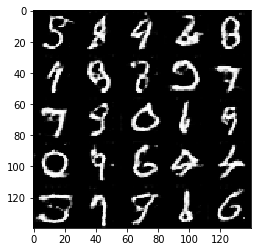

Epoch 2/2 - Batch 1310/1875:  Discriminator loss = 0.5884  Generator loss = 2.0732
Epoch 2/2 - Batch 1320/1875:  Discriminator loss = 0.9523  Generator loss = 0.9146
Epoch 2/2 - Batch 1330/1875:  Discriminator loss = 0.9546  Generator loss = 1.0300
Epoch 2/2 - Batch 1340/1875:  Discriminator loss = 0.6007  Generator loss = 1.8881
Epoch 2/2 - Batch 1350/1875:  Discriminator loss = 0.6016  Generator loss = 2.3398
Epoch 2/2 - Batch 1360/1875:  Discriminator loss = 1.1031  Generator loss = 1.1607
Epoch 2/2 - Batch 1370/1875:  Discriminator loss = 0.9728  Generator loss = 0.9766
Epoch 2/2 - Batch 1380/1875:  Discriminator loss = 0.5537  Generator loss = 2.0334
Epoch 2/2 - Batch 1390/1875:  Discriminator loss = 0.6833  Generator loss = 1.4497
Epoch 2/2 - Batch 1400/1875:  Discriminator loss = 1.0608  Generator loss = 0.8282


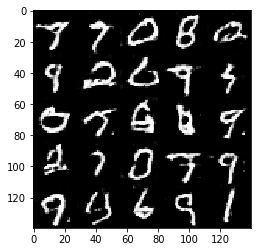

Epoch 2/2 - Batch 1410/1875:  Discriminator loss = 0.5829  Generator loss = 2.1342
Epoch 2/2 - Batch 1420/1875:  Discriminator loss = 1.1200  Generator loss = 0.8867
Epoch 2/2 - Batch 1430/1875:  Discriminator loss = 1.4412  Generator loss = 4.2173
Epoch 2/2 - Batch 1440/1875:  Discriminator loss = 0.7740  Generator loss = 1.9678
Epoch 2/2 - Batch 1450/1875:  Discriminator loss = 0.8782  Generator loss = 1.1355
Epoch 2/2 - Batch 1460/1875:  Discriminator loss = 0.6822  Generator loss = 1.5308
Epoch 2/2 - Batch 1470/1875:  Discriminator loss = 1.0907  Generator loss = 0.8699
Epoch 2/2 - Batch 1480/1875:  Discriminator loss = 0.8229  Generator loss = 1.2046
Epoch 2/2 - Batch 1490/1875:  Discriminator loss = 0.7404  Generator loss = 1.7700
Epoch 2/2 - Batch 1500/1875:  Discriminator loss = 0.6026  Generator loss = 1.9282


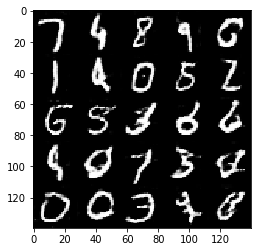

Epoch 2/2 - Batch 1510/1875:  Discriminator loss = 1.8659  Generator loss = 0.3474
Epoch 2/2 - Batch 1520/1875:  Discriminator loss = 0.6377  Generator loss = 1.6237
Epoch 2/2 - Batch 1530/1875:  Discriminator loss = 1.4231  Generator loss = 0.6820
Epoch 2/2 - Batch 1540/1875:  Discriminator loss = 0.6413  Generator loss = 2.1298
Epoch 2/2 - Batch 1550/1875:  Discriminator loss = 0.7489  Generator loss = 1.3139
Epoch 2/2 - Batch 1560/1875:  Discriminator loss = 0.7043  Generator loss = 1.8967
Epoch 2/2 - Batch 1570/1875:  Discriminator loss = 0.6993  Generator loss = 1.7771
Epoch 2/2 - Batch 1580/1875:  Discriminator loss = 1.0591  Generator loss = 0.8824
Epoch 2/2 - Batch 1590/1875:  Discriminator loss = 0.9326  Generator loss = 0.9955
Epoch 2/2 - Batch 1600/1875:  Discriminator loss = 0.7569  Generator loss = 1.4398


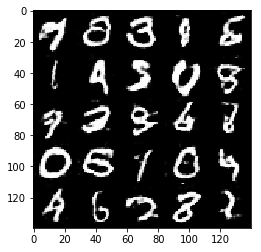

Epoch 2/2 - Batch 1610/1875:  Discriminator loss = 0.7275  Generator loss = 2.4242
Epoch 2/2 - Batch 1620/1875:  Discriminator loss = 1.8515  Generator loss = 0.3434
Epoch 2/2 - Batch 1630/1875:  Discriminator loss = 0.6308  Generator loss = 1.7890
Epoch 2/2 - Batch 1640/1875:  Discriminator loss = 0.7286  Generator loss = 1.4856
Epoch 2/2 - Batch 1650/1875:  Discriminator loss = 0.5859  Generator loss = 1.9085
Epoch 2/2 - Batch 1660/1875:  Discriminator loss = 0.7904  Generator loss = 1.2097
Epoch 2/2 - Batch 1670/1875:  Discriminator loss = 2.1177  Generator loss = 0.2369
Epoch 2/2 - Batch 1680/1875:  Discriminator loss = 0.5105  Generator loss = 2.4106
Epoch 2/2 - Batch 1690/1875:  Discriminator loss = 0.6913  Generator loss = 1.6731
Epoch 2/2 - Batch 1700/1875:  Discriminator loss = 0.7287  Generator loss = 1.6074


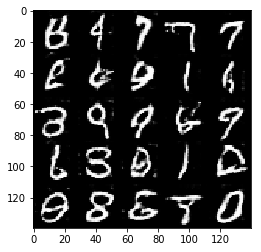

Epoch 2/2 - Batch 1710/1875:  Discriminator loss = 0.6833  Generator loss = 1.5269
Epoch 2/2 - Batch 1720/1875:  Discriminator loss = 0.7420  Generator loss = 1.8061
Epoch 2/2 - Batch 1730/1875:  Discriminator loss = 1.5070  Generator loss = 0.5360
Epoch 2/2 - Batch 1740/1875:  Discriminator loss = 0.9060  Generator loss = 2.2354
Epoch 2/2 - Batch 1750/1875:  Discriminator loss = 0.8494  Generator loss = 1.2583
Epoch 2/2 - Batch 1760/1875:  Discriminator loss = 0.7835  Generator loss = 1.4087
Epoch 2/2 - Batch 1770/1875:  Discriminator loss = 1.2314  Generator loss = 0.6936
Epoch 2/2 - Batch 1780/1875:  Discriminator loss = 0.8447  Generator loss = 1.9769
Epoch 2/2 - Batch 1790/1875:  Discriminator loss = 0.6913  Generator loss = 1.9407
Epoch 2/2 - Batch 1800/1875:  Discriminator loss = 0.6261  Generator loss = 1.7747


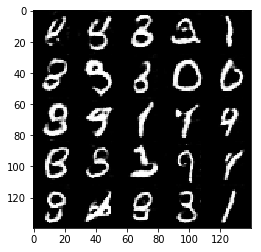

Epoch 2/2 - Batch 1810/1875:  Discriminator loss = 0.7720  Generator loss = 1.4388
Epoch 2/2 - Batch 1820/1875:  Discriminator loss = 0.6921  Generator loss = 1.6330
Epoch 2/2 - Batch 1830/1875:  Discriminator loss = 1.7824  Generator loss = 0.3777
Epoch 2/2 - Batch 1840/1875:  Discriminator loss = 0.7342  Generator loss = 1.6047
Epoch 2/2 - Batch 1850/1875:  Discriminator loss = 0.7476  Generator loss = 1.4316
Epoch 2/2 - Batch 1860/1875:  Discriminator loss = 1.7735  Generator loss = 0.4263
Epoch 2/2 - Batch 1870/1875:  Discriminator loss = 0.7146  Generator loss = 1.5114


In [62]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5
n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 - Batch 10/6331:  Discriminator loss = 0.6934  Generator loss = 6.8531
Epoch 1/1 - Batch 20/6331:  Discriminator loss = 0.7862  Generator loss = 1.8061
Epoch 1/1 - Batch 30/6331:  Discriminator loss = 1.6705  Generator loss = 2.3963
Epoch 1/1 - Batch 40/6331:  Discriminator loss = 1.4130  Generator loss = 0.7390
Epoch 1/1 - Batch 50/6331:  Discriminator loss = 1.2860  Generator loss = 5.4886
Epoch 1/1 - Batch 60/6331:  Discriminator loss = 1.2408  Generator loss = 0.7400
Epoch 1/1 - Batch 70/6331:  Discriminator loss = 0.8880  Generator loss = 1.2334
Epoch 1/1 - Batch 80/6331:  Discriminator loss = 0.8166  Generator loss = 1.6895
Epoch 1/1 - Batch 90/6331:  Discriminator loss = 0.9623  Generator loss = 1.2135
Epoch 1/1 - Batch 100/6331:  Discriminator loss = 1.3387  Generator loss = 3.9276


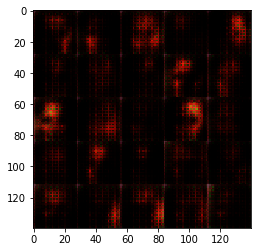

Epoch 1/1 - Batch 110/6331:  Discriminator loss = 0.5386  Generator loss = 2.7978
Epoch 1/1 - Batch 120/6331:  Discriminator loss = 0.6709  Generator loss = 2.0351
Epoch 1/1 - Batch 130/6331:  Discriminator loss = 0.6022  Generator loss = 2.0784
Epoch 1/1 - Batch 140/6331:  Discriminator loss = 0.4987  Generator loss = 2.9226
Epoch 1/1 - Batch 150/6331:  Discriminator loss = 1.5729  Generator loss = 3.5102
Epoch 1/1 - Batch 160/6331:  Discriminator loss = 0.5069  Generator loss = 2.9043
Epoch 1/1 - Batch 170/6331:  Discriminator loss = 1.3947  Generator loss = 0.5641
Epoch 1/1 - Batch 180/6331:  Discriminator loss = 0.6275  Generator loss = 2.3129
Epoch 1/1 - Batch 190/6331:  Discriminator loss = 0.9519  Generator loss = 3.8123
Epoch 1/1 - Batch 200/6331:  Discriminator loss = 0.4574  Generator loss = 4.4299


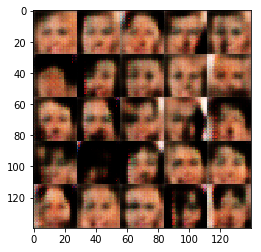

Epoch 1/1 - Batch 210/6331:  Discriminator loss = 2.4170  Generator loss = 5.6167
Epoch 1/1 - Batch 220/6331:  Discriminator loss = 0.7470  Generator loss = 1.6669
Epoch 1/1 - Batch 230/6331:  Discriminator loss = 0.7816  Generator loss = 2.6594
Epoch 1/1 - Batch 240/6331:  Discriminator loss = 1.6660  Generator loss = 2.5270
Epoch 1/1 - Batch 250/6331:  Discriminator loss = 0.8219  Generator loss = 1.7039
Epoch 1/1 - Batch 260/6331:  Discriminator loss = 0.6756  Generator loss = 1.7982
Epoch 1/1 - Batch 270/6331:  Discriminator loss = 0.5274  Generator loss = 2.5413
Epoch 1/1 - Batch 280/6331:  Discriminator loss = 0.6070  Generator loss = 1.8836
Epoch 1/1 - Batch 290/6331:  Discriminator loss = 0.3810  Generator loss = 3.7136
Epoch 1/1 - Batch 300/6331:  Discriminator loss = 0.5461  Generator loss = 3.3124


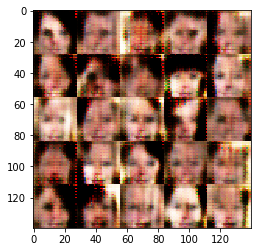

Epoch 1/1 - Batch 310/6331:  Discriminator loss = 0.3940  Generator loss = 6.1176
Epoch 1/1 - Batch 320/6331:  Discriminator loss = 0.8583  Generator loss = 1.3803
Epoch 1/1 - Batch 330/6331:  Discriminator loss = 0.5095  Generator loss = 2.7182
Epoch 1/1 - Batch 340/6331:  Discriminator loss = 1.8216  Generator loss = 2.7124
Epoch 1/1 - Batch 350/6331:  Discriminator loss = 1.6054  Generator loss = 3.9875
Epoch 1/1 - Batch 360/6331:  Discriminator loss = 0.6079  Generator loss = 2.0364
Epoch 1/1 - Batch 370/6331:  Discriminator loss = 0.5593  Generator loss = 5.0567
Epoch 1/1 - Batch 380/6331:  Discriminator loss = 0.4061  Generator loss = 3.9990
Epoch 1/1 - Batch 390/6331:  Discriminator loss = 0.9651  Generator loss = 1.3105
Epoch 1/1 - Batch 400/6331:  Discriminator loss = 0.8332  Generator loss = 1.1122


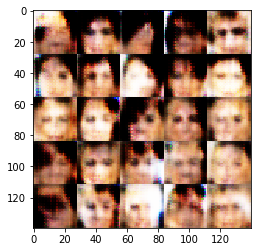

Epoch 1/1 - Batch 410/6331:  Discriminator loss = 0.5537  Generator loss = 3.2422
Epoch 1/1 - Batch 420/6331:  Discriminator loss = 0.5979  Generator loss = 2.2010
Epoch 1/1 - Batch 430/6331:  Discriminator loss = 0.7872  Generator loss = 1.9492
Epoch 1/1 - Batch 440/6331:  Discriminator loss = 0.3698  Generator loss = 4.7037
Epoch 1/1 - Batch 450/6331:  Discriminator loss = 0.5137  Generator loss = 2.4160
Epoch 1/1 - Batch 460/6331:  Discriminator loss = 1.6411  Generator loss = 5.8163
Epoch 1/1 - Batch 470/6331:  Discriminator loss = 0.5177  Generator loss = 2.9918
Epoch 1/1 - Batch 480/6331:  Discriminator loss = 0.6094  Generator loss = 1.9054
Epoch 1/1 - Batch 490/6331:  Discriminator loss = 2.6575  Generator loss = 3.5424
Epoch 1/1 - Batch 500/6331:  Discriminator loss = 0.5867  Generator loss = 2.2019


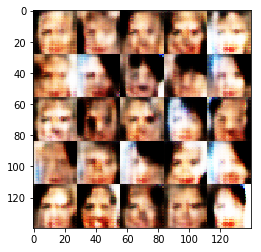

Epoch 1/1 - Batch 510/6331:  Discriminator loss = 1.4867  Generator loss = 0.7843
Epoch 1/1 - Batch 520/6331:  Discriminator loss = 0.9258  Generator loss = 3.3412
Epoch 1/1 - Batch 530/6331:  Discriminator loss = 1.1658  Generator loss = 0.8861
Epoch 1/1 - Batch 540/6331:  Discriminator loss = 1.1879  Generator loss = 4.2172
Epoch 1/1 - Batch 550/6331:  Discriminator loss = 0.5301  Generator loss = 2.1865
Epoch 1/1 - Batch 560/6331:  Discriminator loss = 0.8081  Generator loss = 1.6325
Epoch 1/1 - Batch 570/6331:  Discriminator loss = 1.2807  Generator loss = 1.5362
Epoch 1/1 - Batch 580/6331:  Discriminator loss = 0.5434  Generator loss = 2.9286
Epoch 1/1 - Batch 590/6331:  Discriminator loss = 1.2846  Generator loss = 1.0424
Epoch 1/1 - Batch 600/6331:  Discriminator loss = 0.9662  Generator loss = 1.2221


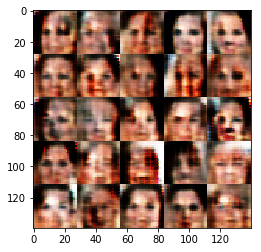

Epoch 1/1 - Batch 610/6331:  Discriminator loss = 0.4529  Generator loss = 2.7373
Epoch 1/1 - Batch 620/6331:  Discriminator loss = 0.9523  Generator loss = 2.0099
Epoch 1/1 - Batch 630/6331:  Discriminator loss = 0.7713  Generator loss = 1.4768
Epoch 1/1 - Batch 640/6331:  Discriminator loss = 0.4212  Generator loss = 3.8441
Epoch 1/1 - Batch 650/6331:  Discriminator loss = 0.5097  Generator loss = 3.0972
Epoch 1/1 - Batch 660/6331:  Discriminator loss = 0.6918  Generator loss = 1.9607
Epoch 1/1 - Batch 670/6331:  Discriminator loss = 0.6017  Generator loss = 2.1867
Epoch 1/1 - Batch 680/6331:  Discriminator loss = 0.4705  Generator loss = 3.1394
Epoch 1/1 - Batch 690/6331:  Discriminator loss = 0.4362  Generator loss = 5.6956
Epoch 1/1 - Batch 700/6331:  Discriminator loss = 0.4182  Generator loss = 6.0410


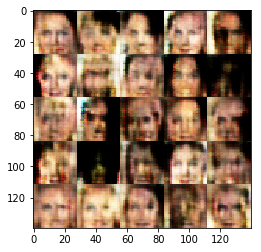

Epoch 1/1 - Batch 710/6331:  Discriminator loss = 1.1264  Generator loss = 2.7463
Epoch 1/1 - Batch 720/6331:  Discriminator loss = 0.5213  Generator loss = 3.9849
Epoch 1/1 - Batch 730/6331:  Discriminator loss = 0.5647  Generator loss = 3.1079
Epoch 1/1 - Batch 740/6331:  Discriminator loss = 1.8171  Generator loss = 0.3903
Epoch 1/1 - Batch 750/6331:  Discriminator loss = 1.2950  Generator loss = 0.8109
Epoch 1/1 - Batch 760/6331:  Discriminator loss = 1.2707  Generator loss = 0.9044
Epoch 1/1 - Batch 770/6331:  Discriminator loss = 0.4703  Generator loss = 3.3675
Epoch 1/1 - Batch 780/6331:  Discriminator loss = 2.0908  Generator loss = 0.3058
Epoch 1/1 - Batch 790/6331:  Discriminator loss = 1.5773  Generator loss = 4.5256
Epoch 1/1 - Batch 800/6331:  Discriminator loss = 0.4749  Generator loss = 3.7300


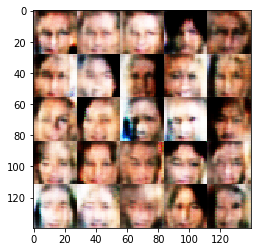

Epoch 1/1 - Batch 810/6331:  Discriminator loss = 1.0742  Generator loss = 2.1020
Epoch 1/1 - Batch 820/6331:  Discriminator loss = 0.6165  Generator loss = 2.0373
Epoch 1/1 - Batch 830/6331:  Discriminator loss = 0.5395  Generator loss = 2.7534
Epoch 1/1 - Batch 840/6331:  Discriminator loss = 0.3903  Generator loss = 4.5766
Epoch 1/1 - Batch 850/6331:  Discriminator loss = 0.6619  Generator loss = 1.9549
Epoch 1/1 - Batch 860/6331:  Discriminator loss = 0.3948  Generator loss = 4.3001
Epoch 1/1 - Batch 870/6331:  Discriminator loss = 0.4451  Generator loss = 2.9374
Epoch 1/1 - Batch 880/6331:  Discriminator loss = 0.7438  Generator loss = 4.3755
Epoch 1/1 - Batch 890/6331:  Discriminator loss = 0.4604  Generator loss = 3.3944
Epoch 1/1 - Batch 900/6331:  Discriminator loss = 0.6801  Generator loss = 1.7540


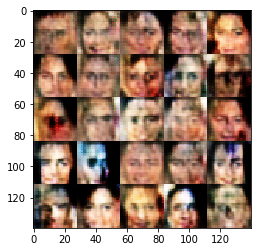

Epoch 1/1 - Batch 910/6331:  Discriminator loss = 0.8220  Generator loss = 1.7468
Epoch 1/1 - Batch 920/6331:  Discriminator loss = 0.4990  Generator loss = 2.9192
Epoch 1/1 - Batch 930/6331:  Discriminator loss = 1.8083  Generator loss = 3.7928
Epoch 1/1 - Batch 940/6331:  Discriminator loss = 0.3747  Generator loss = 4.9631
Epoch 1/1 - Batch 950/6331:  Discriminator loss = 0.4373  Generator loss = 2.8094
Epoch 1/1 - Batch 960/6331:  Discriminator loss = 0.4041  Generator loss = 3.1012
Epoch 1/1 - Batch 970/6331:  Discriminator loss = 0.4433  Generator loss = 3.1656
Epoch 1/1 - Batch 980/6331:  Discriminator loss = 0.7036  Generator loss = 3.3462
Epoch 1/1 - Batch 990/6331:  Discriminator loss = 0.4100  Generator loss = 3.7681
Epoch 1/1 - Batch 1000/6331:  Discriminator loss = 0.4250  Generator loss = 3.6128


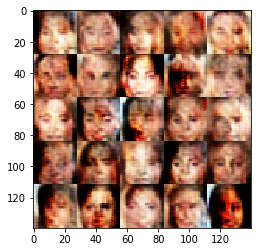

Epoch 1/1 - Batch 1010/6331:  Discriminator loss = 0.4197  Generator loss = 4.9885
Epoch 1/1 - Batch 1020/6331:  Discriminator loss = 0.5842  Generator loss = 1.9602
Epoch 1/1 - Batch 1030/6331:  Discriminator loss = 0.3701  Generator loss = 4.9683
Epoch 1/1 - Batch 1040/6331:  Discriminator loss = 0.3567  Generator loss = 5.2798
Epoch 1/1 - Batch 1050/6331:  Discriminator loss = 0.7519  Generator loss = 3.9726
Epoch 1/1 - Batch 1060/6331:  Discriminator loss = 1.1262  Generator loss = 0.9334
Epoch 1/1 - Batch 1070/6331:  Discriminator loss = 1.7115  Generator loss = 0.4669
Epoch 1/1 - Batch 1080/6331:  Discriminator loss = 1.3466  Generator loss = 1.2716
Epoch 1/1 - Batch 1090/6331:  Discriminator loss = 1.3214  Generator loss = 0.9034
Epoch 1/1 - Batch 1100/6331:  Discriminator loss = 0.9188  Generator loss = 1.3335


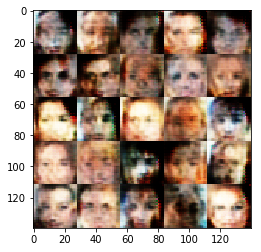

Epoch 1/1 - Batch 1110/6331:  Discriminator loss = 0.7141  Generator loss = 1.6939
Epoch 1/1 - Batch 1120/6331:  Discriminator loss = 1.2397  Generator loss = 0.8999
Epoch 1/1 - Batch 1130/6331:  Discriminator loss = 0.6216  Generator loss = 1.9087
Epoch 1/1 - Batch 1140/6331:  Discriminator loss = 0.7234  Generator loss = 1.6473
Epoch 1/1 - Batch 1150/6331:  Discriminator loss = 1.0611  Generator loss = 1.0506
Epoch 1/1 - Batch 1160/6331:  Discriminator loss = 1.6839  Generator loss = 0.4897
Epoch 1/1 - Batch 1170/6331:  Discriminator loss = 0.4341  Generator loss = 5.1015
Epoch 1/1 - Batch 1180/6331:  Discriminator loss = 0.4134  Generator loss = 5.1712
Epoch 1/1 - Batch 1190/6331:  Discriminator loss = 0.4020  Generator loss = 3.2105
Epoch 1/1 - Batch 1200/6331:  Discriminator loss = 0.4519  Generator loss = 3.1033


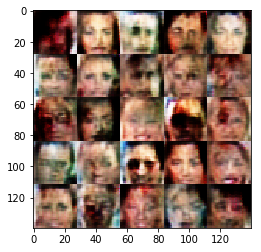

Epoch 1/1 - Batch 1210/6331:  Discriminator loss = 0.7581  Generator loss = 1.6622
Epoch 1/1 - Batch 1220/6331:  Discriminator loss = 0.7864  Generator loss = 1.4903
Epoch 1/1 - Batch 1230/6331:  Discriminator loss = 0.8207  Generator loss = 1.8376
Epoch 1/1 - Batch 1240/6331:  Discriminator loss = 1.3009  Generator loss = 4.0842
Epoch 1/1 - Batch 1250/6331:  Discriminator loss = 0.8263  Generator loss = 1.4542
Epoch 1/1 - Batch 1260/6331:  Discriminator loss = 0.8399  Generator loss = 1.3286
Epoch 1/1 - Batch 1270/6331:  Discriminator loss = 0.8876  Generator loss = 1.3895
Epoch 1/1 - Batch 1280/6331:  Discriminator loss = 0.4356  Generator loss = 3.5019
Epoch 1/1 - Batch 1290/6331:  Discriminator loss = 0.5036  Generator loss = 2.6627
Epoch 1/1 - Batch 1300/6331:  Discriminator loss = 0.6754  Generator loss = 1.7516


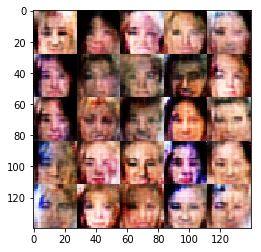

Epoch 1/1 - Batch 1310/6331:  Discriminator loss = 0.8292  Generator loss = 1.7249
Epoch 1/1 - Batch 1320/6331:  Discriminator loss = 0.8583  Generator loss = 1.3942
Epoch 1/1 - Batch 1330/6331:  Discriminator loss = 0.4953  Generator loss = 2.7779
Epoch 1/1 - Batch 1340/6331:  Discriminator loss = 0.7179  Generator loss = 1.8694
Epoch 1/1 - Batch 1350/6331:  Discriminator loss = 0.4768  Generator loss = 2.6844
Epoch 1/1 - Batch 1360/6331:  Discriminator loss = 0.4655  Generator loss = 2.7624
Epoch 1/1 - Batch 1370/6331:  Discriminator loss = 1.4474  Generator loss = 2.4231
Epoch 1/1 - Batch 1380/6331:  Discriminator loss = 1.3260  Generator loss = 0.7643
Epoch 1/1 - Batch 1390/6331:  Discriminator loss = 1.7173  Generator loss = 0.4375
Epoch 1/1 - Batch 1400/6331:  Discriminator loss = 1.4078  Generator loss = 3.3631


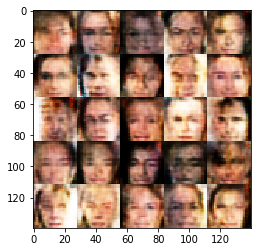

Epoch 1/1 - Batch 1410/6331:  Discriminator loss = 2.7012  Generator loss = 0.1633
Epoch 1/1 - Batch 1420/6331:  Discriminator loss = 1.1576  Generator loss = 0.9898
Epoch 1/1 - Batch 1430/6331:  Discriminator loss = 0.8058  Generator loss = 1.4303
Epoch 1/1 - Batch 1440/6331:  Discriminator loss = 0.5196  Generator loss = 2.3442
Epoch 1/1 - Batch 1450/6331:  Discriminator loss = 1.0545  Generator loss = 4.5317
Epoch 1/1 - Batch 1460/6331:  Discriminator loss = 0.6642  Generator loss = 2.3026
Epoch 1/1 - Batch 1470/6331:  Discriminator loss = 1.0949  Generator loss = 1.4655
Epoch 1/1 - Batch 1480/6331:  Discriminator loss = 0.6742  Generator loss = 4.1855
Epoch 1/1 - Batch 1490/6331:  Discriminator loss = 0.5859  Generator loss = 2.3455
Epoch 1/1 - Batch 1500/6331:  Discriminator loss = 0.5444  Generator loss = 3.1847


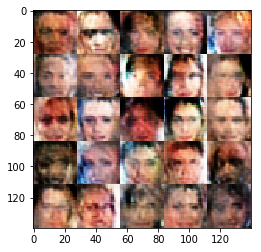

Epoch 1/1 - Batch 1510/6331:  Discriminator loss = 0.7669  Generator loss = 3.3705
Epoch 1/1 - Batch 1520/6331:  Discriminator loss = 1.5780  Generator loss = 2.6362
Epoch 1/1 - Batch 1530/6331:  Discriminator loss = 0.5567  Generator loss = 2.2219
Epoch 1/1 - Batch 1540/6331:  Discriminator loss = 0.4710  Generator loss = 3.2782
Epoch 1/1 - Batch 1550/6331:  Discriminator loss = 1.4872  Generator loss = 2.4788
Epoch 1/1 - Batch 1560/6331:  Discriminator loss = 0.5072  Generator loss = 2.4243
Epoch 1/1 - Batch 1570/6331:  Discriminator loss = 0.4375  Generator loss = 3.7569
Epoch 1/1 - Batch 1580/6331:  Discriminator loss = 1.7162  Generator loss = 6.4065
Epoch 1/1 - Batch 1590/6331:  Discriminator loss = 0.9890  Generator loss = 1.3108
Epoch 1/1 - Batch 1600/6331:  Discriminator loss = 0.5014  Generator loss = 2.4303


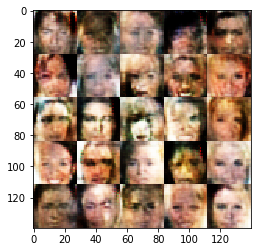

Epoch 1/1 - Batch 1610/6331:  Discriminator loss = 2.2747  Generator loss = 5.8092
Epoch 1/1 - Batch 1620/6331:  Discriminator loss = 0.4727  Generator loss = 2.8194
Epoch 1/1 - Batch 1630/6331:  Discriminator loss = 0.7426  Generator loss = 1.6955
Epoch 1/1 - Batch 1640/6331:  Discriminator loss = 0.3578  Generator loss = 4.9193
Epoch 1/1 - Batch 1650/6331:  Discriminator loss = 3.2410  Generator loss = 0.1405
Epoch 1/1 - Batch 1660/6331:  Discriminator loss = 0.6797  Generator loss = 1.7194
Epoch 1/1 - Batch 1670/6331:  Discriminator loss = 0.5722  Generator loss = 2.7953
Epoch 1/1 - Batch 1680/6331:  Discriminator loss = 0.8834  Generator loss = 2.7230
Epoch 1/1 - Batch 1690/6331:  Discriminator loss = 0.4665  Generator loss = 4.0535
Epoch 1/1 - Batch 1700/6331:  Discriminator loss = 0.7125  Generator loss = 1.8117


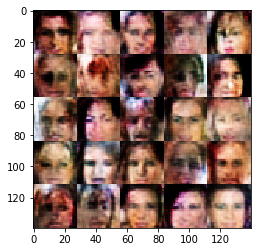

Epoch 1/1 - Batch 1710/6331:  Discriminator loss = 1.6788  Generator loss = 0.5435
Epoch 1/1 - Batch 1720/6331:  Discriminator loss = 0.3911  Generator loss = 4.3104
Epoch 1/1 - Batch 1730/6331:  Discriminator loss = 0.7164  Generator loss = 1.4953
Epoch 1/1 - Batch 1740/6331:  Discriminator loss = 0.4025  Generator loss = 3.5305
Epoch 1/1 - Batch 1750/6331:  Discriminator loss = 0.3945  Generator loss = 4.4335
Epoch 1/1 - Batch 1760/6331:  Discriminator loss = 0.3817  Generator loss = 4.7086
Epoch 1/1 - Batch 1770/6331:  Discriminator loss = 0.6748  Generator loss = 1.9521
Epoch 1/1 - Batch 1780/6331:  Discriminator loss = 0.4159  Generator loss = 4.2315
Epoch 1/1 - Batch 1790/6331:  Discriminator loss = 0.3737  Generator loss = 4.5346
Epoch 1/1 - Batch 1800/6331:  Discriminator loss = 0.7810  Generator loss = 1.5172


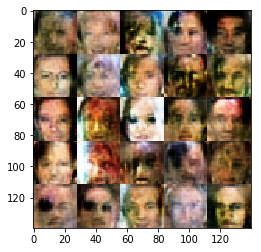

Epoch 1/1 - Batch 1810/6331:  Discriminator loss = 0.9967  Generator loss = 1.4128
Epoch 1/1 - Batch 1820/6331:  Discriminator loss = 0.3962  Generator loss = 4.1786
Epoch 1/1 - Batch 1830/6331:  Discriminator loss = 1.5380  Generator loss = 1.5811
Epoch 1/1 - Batch 1840/6331:  Discriminator loss = 0.6452  Generator loss = 1.9650
Epoch 1/1 - Batch 1850/6331:  Discriminator loss = 0.4901  Generator loss = 2.6371
Epoch 1/1 - Batch 1860/6331:  Discriminator loss = 0.4107  Generator loss = 4.1062
Epoch 1/1 - Batch 1870/6331:  Discriminator loss = 0.3829  Generator loss = 4.3314
Epoch 1/1 - Batch 1880/6331:  Discriminator loss = 0.4128  Generator loss = 3.2050
Epoch 1/1 - Batch 1890/6331:  Discriminator loss = 0.5459  Generator loss = 2.0227
Epoch 1/1 - Batch 1900/6331:  Discriminator loss = 0.7239  Generator loss = 2.0403


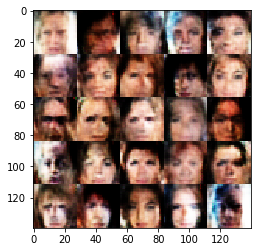

Epoch 1/1 - Batch 1910/6331:  Discriminator loss = 1.0661  Generator loss = 1.0349
Epoch 1/1 - Batch 1920/6331:  Discriminator loss = 0.8176  Generator loss = 1.4214
Epoch 1/1 - Batch 1930/6331:  Discriminator loss = 0.7525  Generator loss = 1.7973
Epoch 1/1 - Batch 1940/6331:  Discriminator loss = 1.1786  Generator loss = 1.0775
Epoch 1/1 - Batch 1950/6331:  Discriminator loss = 0.9246  Generator loss = 1.5266
Epoch 1/1 - Batch 1960/6331:  Discriminator loss = 0.4144  Generator loss = 4.0045
Epoch 1/1 - Batch 1970/6331:  Discriminator loss = 0.6520  Generator loss = 4.4387
Epoch 1/1 - Batch 1980/6331:  Discriminator loss = 0.4945  Generator loss = 2.6592
Epoch 1/1 - Batch 1990/6331:  Discriminator loss = 0.5520  Generator loss = 2.3564
Epoch 1/1 - Batch 2000/6331:  Discriminator loss = 0.6675  Generator loss = 5.2733


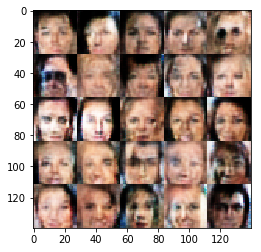

Epoch 1/1 - Batch 2010/6331:  Discriminator loss = 0.6148  Generator loss = 2.5896
Epoch 1/1 - Batch 2020/6331:  Discriminator loss = 1.8512  Generator loss = 0.3862
Epoch 1/1 - Batch 2030/6331:  Discriminator loss = 2.9193  Generator loss = 0.1936
Epoch 1/1 - Batch 2040/6331:  Discriminator loss = 0.8797  Generator loss = 1.3411
Epoch 1/1 - Batch 2050/6331:  Discriminator loss = 1.3306  Generator loss = 0.7883
Epoch 1/1 - Batch 2060/6331:  Discriminator loss = 0.4881  Generator loss = 4.2505
Epoch 1/1 - Batch 2070/6331:  Discriminator loss = 1.1920  Generator loss = 2.0211
Epoch 1/1 - Batch 2080/6331:  Discriminator loss = 0.6967  Generator loss = 1.8836
Epoch 1/1 - Batch 2090/6331:  Discriminator loss = 0.5183  Generator loss = 3.4868
Epoch 1/1 - Batch 2100/6331:  Discriminator loss = 0.5810  Generator loss = 2.8574


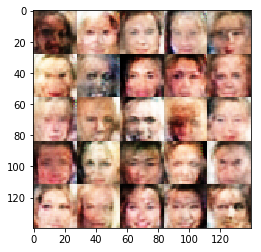

Epoch 1/1 - Batch 2110/6331:  Discriminator loss = 0.7479  Generator loss = 1.6612
Epoch 1/1 - Batch 2120/6331:  Discriminator loss = 0.4136  Generator loss = 3.3284
Epoch 1/1 - Batch 2130/6331:  Discriminator loss = 0.4139  Generator loss = 3.9955
Epoch 1/1 - Batch 2140/6331:  Discriminator loss = 1.6798  Generator loss = 0.4316
Epoch 1/1 - Batch 2150/6331:  Discriminator loss = 1.2134  Generator loss = 0.8562
Epoch 1/1 - Batch 2160/6331:  Discriminator loss = 0.5143  Generator loss = 2.9945
Epoch 1/1 - Batch 2170/6331:  Discriminator loss = 0.4269  Generator loss = 3.1702
Epoch 1/1 - Batch 2180/6331:  Discriminator loss = 1.7808  Generator loss = 3.5208
Epoch 1/1 - Batch 2190/6331:  Discriminator loss = 0.6631  Generator loss = 1.7807
Epoch 1/1 - Batch 2200/6331:  Discriminator loss = 0.6227  Generator loss = 1.9949


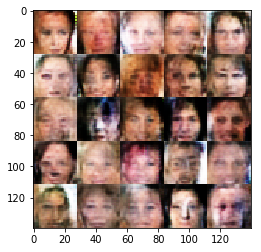

Epoch 1/1 - Batch 2210/6331:  Discriminator loss = 0.6359  Generator loss = 2.0290
Epoch 1/1 - Batch 2220/6331:  Discriminator loss = 0.7986  Generator loss = 2.9314
Epoch 1/1 - Batch 2230/6331:  Discriminator loss = 0.4660  Generator loss = 2.6578
Epoch 1/1 - Batch 2240/6331:  Discriminator loss = 0.3716  Generator loss = 4.8366
Epoch 1/1 - Batch 2250/6331:  Discriminator loss = 0.5136  Generator loss = 2.4185
Epoch 1/1 - Batch 2260/6331:  Discriminator loss = 0.6367  Generator loss = 3.2353
Epoch 1/1 - Batch 2270/6331:  Discriminator loss = 0.4505  Generator loss = 3.0774
Epoch 1/1 - Batch 2280/6331:  Discriminator loss = 0.3830  Generator loss = 4.0813
Epoch 1/1 - Batch 2290/6331:  Discriminator loss = 0.9301  Generator loss = 1.2727
Epoch 1/1 - Batch 2300/6331:  Discriminator loss = 1.7360  Generator loss = 0.3975


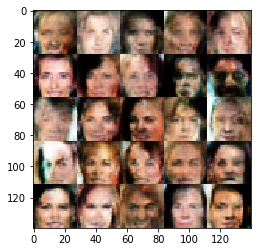

Epoch 1/1 - Batch 2310/6331:  Discriminator loss = 0.4049  Generator loss = 4.2508
Epoch 1/1 - Batch 2320/6331:  Discriminator loss = 1.3408  Generator loss = 0.8073
Epoch 1/1 - Batch 2330/6331:  Discriminator loss = 0.4868  Generator loss = 2.3616
Epoch 1/1 - Batch 2340/6331:  Discriminator loss = 0.7693  Generator loss = 3.7448
Epoch 1/1 - Batch 2350/6331:  Discriminator loss = 0.4044  Generator loss = 4.4136
Epoch 1/1 - Batch 2360/6331:  Discriminator loss = 0.4120  Generator loss = 4.7121
Epoch 1/1 - Batch 2370/6331:  Discriminator loss = 0.5687  Generator loss = 2.7750
Epoch 1/1 - Batch 2380/6331:  Discriminator loss = 0.5024  Generator loss = 2.3079
Epoch 1/1 - Batch 2390/6331:  Discriminator loss = 0.3941  Generator loss = 3.6758
Epoch 1/1 - Batch 2400/6331:  Discriminator loss = 0.3497  Generator loss = 5.1429


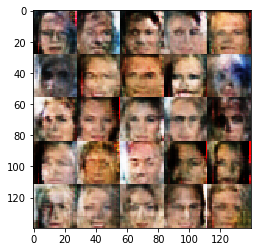

Epoch 1/1 - Batch 2410/6331:  Discriminator loss = 0.4114  Generator loss = 3.2729
Epoch 1/1 - Batch 2420/6331:  Discriminator loss = 0.4299  Generator loss = 3.4662
Epoch 1/1 - Batch 2430/6331:  Discriminator loss = 1.5940  Generator loss = 3.5209
Epoch 1/1 - Batch 2440/6331:  Discriminator loss = 0.7701  Generator loss = 1.4722
Epoch 1/1 - Batch 2450/6331:  Discriminator loss = 1.0951  Generator loss = 0.8366
Epoch 1/1 - Batch 2460/6331:  Discriminator loss = 1.2910  Generator loss = 2.6993
Epoch 1/1 - Batch 2470/6331:  Discriminator loss = 0.8687  Generator loss = 1.2425
Epoch 1/1 - Batch 2480/6331:  Discriminator loss = 0.6252  Generator loss = 2.1742
Epoch 1/1 - Batch 2490/6331:  Discriminator loss = 0.8306  Generator loss = 1.2759
Epoch 1/1 - Batch 2500/6331:  Discriminator loss = 0.9598  Generator loss = 1.1485


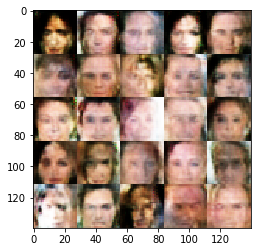

Epoch 1/1 - Batch 2510/6331:  Discriminator loss = 0.8876  Generator loss = 1.1676
Epoch 1/1 - Batch 2520/6331:  Discriminator loss = 0.6051  Generator loss = 1.8617
Epoch 1/1 - Batch 2530/6331:  Discriminator loss = 0.5686  Generator loss = 2.3223
Epoch 1/1 - Batch 2540/6331:  Discriminator loss = 0.4910  Generator loss = 2.6511
Epoch 1/1 - Batch 2550/6331:  Discriminator loss = 0.4411  Generator loss = 3.7924
Epoch 1/1 - Batch 2560/6331:  Discriminator loss = 0.7740  Generator loss = 1.9274
Epoch 1/1 - Batch 2570/6331:  Discriminator loss = 0.4413  Generator loss = 3.8699
Epoch 1/1 - Batch 2580/6331:  Discriminator loss = 0.4559  Generator loss = 3.3344
Epoch 1/1 - Batch 2590/6331:  Discriminator loss = 0.5483  Generator loss = 2.1560
Epoch 1/1 - Batch 2600/6331:  Discriminator loss = 0.4802  Generator loss = 2.8613


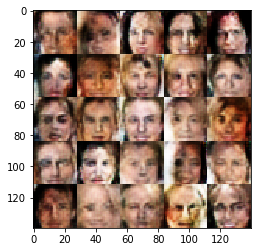

Epoch 1/1 - Batch 2610/6331:  Discriminator loss = 0.9184  Generator loss = 2.4037
Epoch 1/1 - Batch 2620/6331:  Discriminator loss = 1.3338  Generator loss = 0.5743
Epoch 1/1 - Batch 2630/6331:  Discriminator loss = 0.6433  Generator loss = 2.1084
Epoch 1/1 - Batch 2640/6331:  Discriminator loss = 0.5241  Generator loss = 4.6359
Epoch 1/1 - Batch 2650/6331:  Discriminator loss = 1.0403  Generator loss = 0.9614
Epoch 1/1 - Batch 2660/6331:  Discriminator loss = 0.4246  Generator loss = 4.6506
Epoch 1/1 - Batch 2670/6331:  Discriminator loss = 0.6341  Generator loss = 3.6079
Epoch 1/1 - Batch 2680/6331:  Discriminator loss = 0.4611  Generator loss = 3.0421
Epoch 1/1 - Batch 2690/6331:  Discriminator loss = 1.3827  Generator loss = 4.5521
Epoch 1/1 - Batch 2700/6331:  Discriminator loss = 0.5789  Generator loss = 1.8878


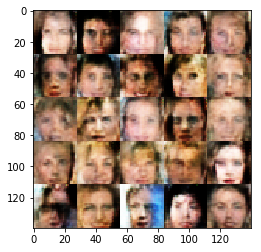

Epoch 1/1 - Batch 2710/6331:  Discriminator loss = 0.4066  Generator loss = 5.2709
Epoch 1/1 - Batch 2720/6331:  Discriminator loss = 0.3958  Generator loss = 6.4525
Epoch 1/1 - Batch 2730/6331:  Discriminator loss = 0.3762  Generator loss = 4.4493
Epoch 1/1 - Batch 2740/6331:  Discriminator loss = 0.4637  Generator loss = 3.6700
Epoch 1/1 - Batch 2750/6331:  Discriminator loss = 0.7350  Generator loss = 1.6814
Epoch 1/1 - Batch 2760/6331:  Discriminator loss = 0.4637  Generator loss = 3.0838
Epoch 1/1 - Batch 2770/6331:  Discriminator loss = 0.7879  Generator loss = 2.3891
Epoch 1/1 - Batch 2780/6331:  Discriminator loss = 0.8036  Generator loss = 1.3723
Epoch 1/1 - Batch 2790/6331:  Discriminator loss = 0.8534  Generator loss = 1.3354
Epoch 1/1 - Batch 2800/6331:  Discriminator loss = 0.8118  Generator loss = 1.2834


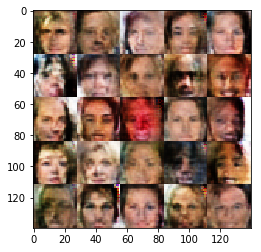

Epoch 1/1 - Batch 2810/6331:  Discriminator loss = 0.8961  Generator loss = 1.6381
Epoch 1/1 - Batch 2820/6331:  Discriminator loss = 0.9960  Generator loss = 1.1957
Epoch 1/1 - Batch 2830/6331:  Discriminator loss = 0.7221  Generator loss = 1.5210
Epoch 1/1 - Batch 2840/6331:  Discriminator loss = 0.5801  Generator loss = 2.2086
Epoch 1/1 - Batch 2850/6331:  Discriminator loss = 1.8255  Generator loss = 0.3921
Epoch 1/1 - Batch 2860/6331:  Discriminator loss = 0.4514  Generator loss = 4.2556
Epoch 1/1 - Batch 2870/6331:  Discriminator loss = 0.4209  Generator loss = 3.5399
Epoch 1/1 - Batch 2880/6331:  Discriminator loss = 0.8616  Generator loss = 6.0257
Epoch 1/1 - Batch 2890/6331:  Discriminator loss = 0.3781  Generator loss = 4.0148
Epoch 1/1 - Batch 2900/6331:  Discriminator loss = 0.4789  Generator loss = 3.9791


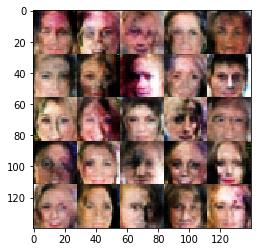

Epoch 1/1 - Batch 2910/6331:  Discriminator loss = 0.7520  Generator loss = 3.6376
Epoch 1/1 - Batch 2920/6331:  Discriminator loss = 1.9236  Generator loss = 0.5080
Epoch 1/1 - Batch 2930/6331:  Discriminator loss = 1.1186  Generator loss = 2.9243
Epoch 1/1 - Batch 2940/6331:  Discriminator loss = 0.4114  Generator loss = 3.2821
Epoch 1/1 - Batch 2950/6331:  Discriminator loss = 0.7968  Generator loss = 3.2763
Epoch 1/1 - Batch 2960/6331:  Discriminator loss = 1.0963  Generator loss = 0.8744
Epoch 1/1 - Batch 2970/6331:  Discriminator loss = 0.7902  Generator loss = 2.4359
Epoch 1/1 - Batch 2980/6331:  Discriminator loss = 0.9495  Generator loss = 1.1043
Epoch 1/1 - Batch 2990/6331:  Discriminator loss = 0.5640  Generator loss = 2.5208
Epoch 1/1 - Batch 3000/6331:  Discriminator loss = 0.5110  Generator loss = 3.2917


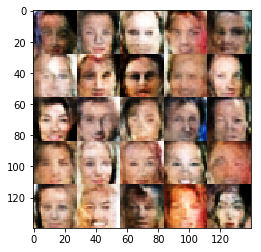

Epoch 1/1 - Batch 3010/6331:  Discriminator loss = 1.8473  Generator loss = 0.4139
Epoch 1/1 - Batch 3020/6331:  Discriminator loss = 0.7392  Generator loss = 4.6663
Epoch 1/1 - Batch 3030/6331:  Discriminator loss = 0.4184  Generator loss = 3.4464
Epoch 1/1 - Batch 3040/6331:  Discriminator loss = 0.7647  Generator loss = 2.0998
Epoch 1/1 - Batch 3050/6331:  Discriminator loss = 0.5961  Generator loss = 1.8969
Epoch 1/1 - Batch 3060/6331:  Discriminator loss = 0.3957  Generator loss = 3.6077
Epoch 1/1 - Batch 3070/6331:  Discriminator loss = 0.4440  Generator loss = 3.8514
Epoch 1/1 - Batch 3080/6331:  Discriminator loss = 0.7696  Generator loss = 1.3110
Epoch 1/1 - Batch 3090/6331:  Discriminator loss = 0.5476  Generator loss = 2.2575
Epoch 1/1 - Batch 3100/6331:  Discriminator loss = 0.5647  Generator loss = 4.0967


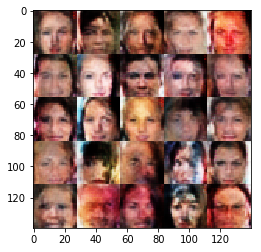

Epoch 1/1 - Batch 3110/6331:  Discriminator loss = 0.4458  Generator loss = 2.9660
Epoch 1/1 - Batch 3120/6331:  Discriminator loss = 0.8820  Generator loss = 1.6287
Epoch 1/1 - Batch 3130/6331:  Discriminator loss = 0.5993  Generator loss = 2.1726
Epoch 1/1 - Batch 3140/6331:  Discriminator loss = 0.3819  Generator loss = 4.5017
Epoch 1/1 - Batch 3150/6331:  Discriminator loss = 0.5011  Generator loss = 2.3906
Epoch 1/1 - Batch 3160/6331:  Discriminator loss = 0.3712  Generator loss = 4.5845
Epoch 1/1 - Batch 3170/6331:  Discriminator loss = 2.1256  Generator loss = 0.3307
Epoch 1/1 - Batch 3180/6331:  Discriminator loss = 0.3857  Generator loss = 3.9289
Epoch 1/1 - Batch 3190/6331:  Discriminator loss = 0.3629  Generator loss = 4.9676
Epoch 1/1 - Batch 3200/6331:  Discriminator loss = 0.5617  Generator loss = 2.2003


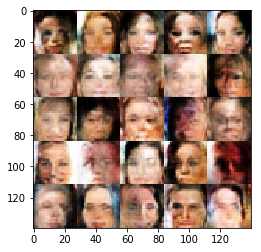

Epoch 1/1 - Batch 3210/6331:  Discriminator loss = 1.1684  Generator loss = 0.8906
Epoch 1/1 - Batch 3220/6331:  Discriminator loss = 0.6324  Generator loss = 1.9566
Epoch 1/1 - Batch 3230/6331:  Discriminator loss = 0.3864  Generator loss = 4.4757
Epoch 1/1 - Batch 3240/6331:  Discriminator loss = 0.6423  Generator loss = 1.9295
Epoch 1/1 - Batch 3250/6331:  Discriminator loss = 1.4214  Generator loss = 0.5532
Epoch 1/1 - Batch 3260/6331:  Discriminator loss = 0.8180  Generator loss = 1.2765
Epoch 1/1 - Batch 3270/6331:  Discriminator loss = 0.4141  Generator loss = 3.4240
Epoch 1/1 - Batch 3280/6331:  Discriminator loss = 1.1182  Generator loss = 1.5667
Epoch 1/1 - Batch 3290/6331:  Discriminator loss = 1.3538  Generator loss = 0.7868
Epoch 1/1 - Batch 3300/6331:  Discriminator loss = 1.4190  Generator loss = 5.1034


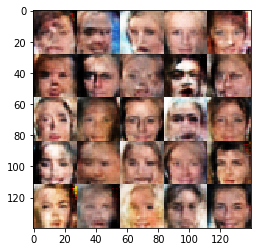

Epoch 1/1 - Batch 3310/6331:  Discriminator loss = 0.5708  Generator loss = 2.4959
Epoch 1/1 - Batch 3320/6331:  Discriminator loss = 0.8338  Generator loss = 1.3389
Epoch 1/1 - Batch 3330/6331:  Discriminator loss = 0.4878  Generator loss = 2.6071
Epoch 1/1 - Batch 3340/6331:  Discriminator loss = 0.6613  Generator loss = 2.2796
Epoch 1/1 - Batch 3350/6331:  Discriminator loss = 1.2438  Generator loss = 0.9099
Epoch 1/1 - Batch 3360/6331:  Discriminator loss = 0.7185  Generator loss = 1.6338
Epoch 1/1 - Batch 3370/6331:  Discriminator loss = 0.6302  Generator loss = 1.8198
Epoch 1/1 - Batch 3380/6331:  Discriminator loss = 0.6321  Generator loss = 1.8506
Epoch 1/1 - Batch 3390/6331:  Discriminator loss = 1.1419  Generator loss = 0.9317
Epoch 1/1 - Batch 3400/6331:  Discriminator loss = 0.9113  Generator loss = 1.4306


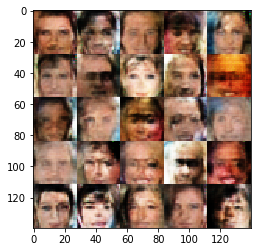

Epoch 1/1 - Batch 3410/6331:  Discriminator loss = 0.7292  Generator loss = 3.2945
Epoch 1/1 - Batch 3420/6331:  Discriminator loss = 0.4329  Generator loss = 4.3319
Epoch 1/1 - Batch 3430/6331:  Discriminator loss = 0.8318  Generator loss = 1.4338
Epoch 1/1 - Batch 3440/6331:  Discriminator loss = 0.6970  Generator loss = 1.5930
Epoch 1/1 - Batch 3450/6331:  Discriminator loss = 0.4379  Generator loss = 2.6403
Epoch 1/1 - Batch 3460/6331:  Discriminator loss = 0.7787  Generator loss = 4.3144
Epoch 1/1 - Batch 3470/6331:  Discriminator loss = 0.4095  Generator loss = 5.1492
Epoch 1/1 - Batch 3480/6331:  Discriminator loss = 0.4472  Generator loss = 2.7840
Epoch 1/1 - Batch 3490/6331:  Discriminator loss = 0.8137  Generator loss = 1.4235
Epoch 1/1 - Batch 3500/6331:  Discriminator loss = 0.8398  Generator loss = 1.2631


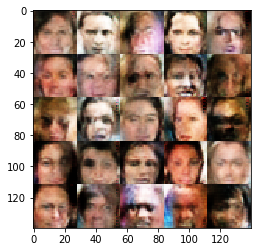

Epoch 1/1 - Batch 3510/6331:  Discriminator loss = 0.4249  Generator loss = 3.5044
Epoch 1/1 - Batch 3520/6331:  Discriminator loss = 2.2137  Generator loss = 4.6839
Epoch 1/1 - Batch 3530/6331:  Discriminator loss = 1.1637  Generator loss = 0.7489
Epoch 1/1 - Batch 3540/6331:  Discriminator loss = 1.7238  Generator loss = 0.5046
Epoch 1/1 - Batch 3550/6331:  Discriminator loss = 1.5836  Generator loss = 0.5688
Epoch 1/1 - Batch 3560/6331:  Discriminator loss = 0.5666  Generator loss = 2.0546
Epoch 1/1 - Batch 3570/6331:  Discriminator loss = 0.4491  Generator loss = 3.3988
Epoch 1/1 - Batch 3580/6331:  Discriminator loss = 0.4512  Generator loss = 3.1070
Epoch 1/1 - Batch 3590/6331:  Discriminator loss = 0.3716  Generator loss = 5.1967
Epoch 1/1 - Batch 3600/6331:  Discriminator loss = 0.7028  Generator loss = 2.6076


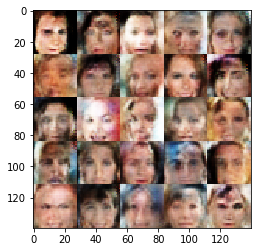

Epoch 1/1 - Batch 3610/6331:  Discriminator loss = 0.4057  Generator loss = 3.3392
Epoch 1/1 - Batch 3620/6331:  Discriminator loss = 0.5187  Generator loss = 2.1751
Epoch 1/1 - Batch 3630/6331:  Discriminator loss = 1.2702  Generator loss = 0.8228
Epoch 1/1 - Batch 3640/6331:  Discriminator loss = 0.4674  Generator loss = 3.0039
Epoch 1/1 - Batch 3650/6331:  Discriminator loss = 0.6662  Generator loss = 4.3342
Epoch 1/1 - Batch 3660/6331:  Discriminator loss = 0.7902  Generator loss = 1.6645
Epoch 1/1 - Batch 3670/6331:  Discriminator loss = 0.5414  Generator loss = 2.5805
Epoch 1/1 - Batch 3680/6331:  Discriminator loss = 0.5300  Generator loss = 2.3625
Epoch 1/1 - Batch 3690/6331:  Discriminator loss = 0.5499  Generator loss = 2.2112
Epoch 1/1 - Batch 3700/6331:  Discriminator loss = 0.9452  Generator loss = 4.8364


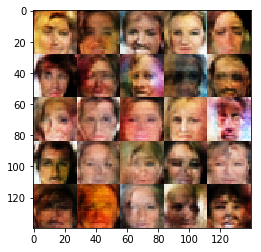

Epoch 1/1 - Batch 3710/6331:  Discriminator loss = 0.5884  Generator loss = 2.2527
Epoch 1/1 - Batch 3720/6331:  Discriminator loss = 0.5424  Generator loss = 3.8385
Epoch 1/1 - Batch 3730/6331:  Discriminator loss = 0.7524  Generator loss = 2.8139
Epoch 1/1 - Batch 3740/6331:  Discriminator loss = 0.9130  Generator loss = 1.0453
Epoch 1/1 - Batch 3750/6331:  Discriminator loss = 0.5346  Generator loss = 2.2462
Epoch 1/1 - Batch 3760/6331:  Discriminator loss = 0.4897  Generator loss = 2.4604
Epoch 1/1 - Batch 3770/6331:  Discriminator loss = 0.6739  Generator loss = 1.7711
Epoch 1/1 - Batch 3780/6331:  Discriminator loss = 0.4683  Generator loss = 3.2365
Epoch 1/1 - Batch 3790/6331:  Discriminator loss = 1.8059  Generator loss = 0.5812
Epoch 1/1 - Batch 3800/6331:  Discriminator loss = 0.9256  Generator loss = 4.9780


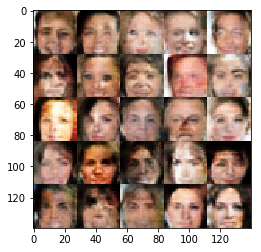

Epoch 1/1 - Batch 3810/6331:  Discriminator loss = 0.4746  Generator loss = 3.0250
Epoch 1/1 - Batch 3820/6331:  Discriminator loss = 1.0842  Generator loss = 0.7864
Epoch 1/1 - Batch 3830/6331:  Discriminator loss = 0.5233  Generator loss = 2.1992
Epoch 1/1 - Batch 3840/6331:  Discriminator loss = 0.5766  Generator loss = 2.1941
Epoch 1/1 - Batch 3850/6331:  Discriminator loss = 1.2809  Generator loss = 4.3687
Epoch 1/1 - Batch 3860/6331:  Discriminator loss = 0.5058  Generator loss = 3.1336
Epoch 1/1 - Batch 3870/6331:  Discriminator loss = 0.5243  Generator loss = 2.3732
Epoch 1/1 - Batch 3880/6331:  Discriminator loss = 0.4139  Generator loss = 3.4069
Epoch 1/1 - Batch 3890/6331:  Discriminator loss = 1.1864  Generator loss = 1.5569
Epoch 1/1 - Batch 3900/6331:  Discriminator loss = 0.5294  Generator loss = 2.5366


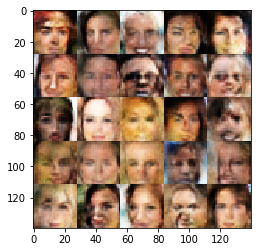

Epoch 1/1 - Batch 3910/6331:  Discriminator loss = 0.6041  Generator loss = 1.9772
Epoch 1/1 - Batch 3920/6331:  Discriminator loss = 0.5057  Generator loss = 2.3857
Epoch 1/1 - Batch 3930/6331:  Discriminator loss = 0.3936  Generator loss = 3.4138
Epoch 1/1 - Batch 3940/6331:  Discriminator loss = 0.7571  Generator loss = 1.4788
Epoch 1/1 - Batch 3950/6331:  Discriminator loss = 0.4852  Generator loss = 3.5585
Epoch 1/1 - Batch 3960/6331:  Discriminator loss = 0.6078  Generator loss = 2.0066
Epoch 1/1 - Batch 3970/6331:  Discriminator loss = 0.3557  Generator loss = 5.2152
Epoch 1/1 - Batch 3980/6331:  Discriminator loss = 0.6788  Generator loss = 7.2258
Epoch 1/1 - Batch 3990/6331:  Discriminator loss = 0.4316  Generator loss = 2.8922
Epoch 1/1 - Batch 4000/6331:  Discriminator loss = 0.4539  Generator loss = 2.8745


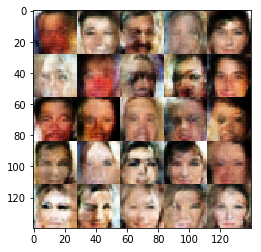

Epoch 1/1 - Batch 4010/6331:  Discriminator loss = 0.5163  Generator loss = 2.2541
Epoch 1/1 - Batch 4020/6331:  Discriminator loss = 0.7550  Generator loss = 1.3281
Epoch 1/1 - Batch 4030/6331:  Discriminator loss = 2.3887  Generator loss = 5.0703
Epoch 1/1 - Batch 4040/6331:  Discriminator loss = 0.5120  Generator loss = 2.5737
Epoch 1/1 - Batch 4050/6331:  Discriminator loss = 0.6706  Generator loss = 2.9468
Epoch 1/1 - Batch 4060/6331:  Discriminator loss = 1.1445  Generator loss = 0.8023
Epoch 1/1 - Batch 4070/6331:  Discriminator loss = 0.3657  Generator loss = 4.3789
Epoch 1/1 - Batch 4080/6331:  Discriminator loss = 0.5329  Generator loss = 2.5172
Epoch 1/1 - Batch 4090/6331:  Discriminator loss = 0.5880  Generator loss = 2.0074
Epoch 1/1 - Batch 4100/6331:  Discriminator loss = 0.6313  Generator loss = 2.0552


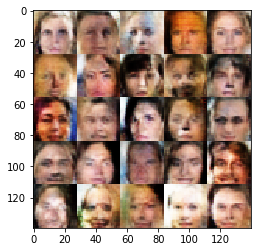

Epoch 1/1 - Batch 4110/6331:  Discriminator loss = 0.5526  Generator loss = 5.4318
Epoch 1/1 - Batch 4120/6331:  Discriminator loss = 0.5226  Generator loss = 2.6609
Epoch 1/1 - Batch 4130/6331:  Discriminator loss = 0.3910  Generator loss = 3.5221
Epoch 1/1 - Batch 4140/6331:  Discriminator loss = 0.7519  Generator loss = 1.5443
Epoch 1/1 - Batch 4150/6331:  Discriminator loss = 0.4338  Generator loss = 5.6268
Epoch 1/1 - Batch 4160/6331:  Discriminator loss = 0.3608  Generator loss = 5.1868
Epoch 1/1 - Batch 4170/6331:  Discriminator loss = 0.5201  Generator loss = 5.8400
Epoch 1/1 - Batch 4180/6331:  Discriminator loss = 0.4267  Generator loss = 4.2541
Epoch 1/1 - Batch 4190/6331:  Discriminator loss = 0.3829  Generator loss = 4.2308
Epoch 1/1 - Batch 4200/6331:  Discriminator loss = 1.4746  Generator loss = 5.3991


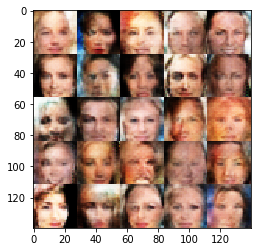

Epoch 1/1 - Batch 4210/6331:  Discriminator loss = 1.1010  Generator loss = 2.8506
Epoch 1/1 - Batch 4220/6331:  Discriminator loss = 0.5616  Generator loss = 2.2141
Epoch 1/1 - Batch 4230/6331:  Discriminator loss = 0.6276  Generator loss = 2.8748
Epoch 1/1 - Batch 4240/6331:  Discriminator loss = 0.5456  Generator loss = 4.0961
Epoch 1/1 - Batch 4250/6331:  Discriminator loss = 0.3791  Generator loss = 4.9871
Epoch 1/1 - Batch 4260/6331:  Discriminator loss = 1.3842  Generator loss = 0.7629
Epoch 1/1 - Batch 4270/6331:  Discriminator loss = 0.4251  Generator loss = 3.8820
Epoch 1/1 - Batch 4280/6331:  Discriminator loss = 0.4087  Generator loss = 3.7069
Epoch 1/1 - Batch 4290/6331:  Discriminator loss = 0.8757  Generator loss = 1.2166
Epoch 1/1 - Batch 4300/6331:  Discriminator loss = 0.4434  Generator loss = 3.6400


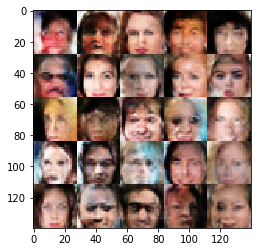

Epoch 1/1 - Batch 4310/6331:  Discriminator loss = 0.6563  Generator loss = 4.0616
Epoch 1/1 - Batch 4320/6331:  Discriminator loss = 0.6943  Generator loss = 1.5617
Epoch 1/1 - Batch 4330/6331:  Discriminator loss = 0.5303  Generator loss = 3.6756
Epoch 1/1 - Batch 4340/6331:  Discriminator loss = 0.4018  Generator loss = 3.6924
Epoch 1/1 - Batch 4350/6331:  Discriminator loss = 0.7678  Generator loss = 4.3522
Epoch 1/1 - Batch 4360/6331:  Discriminator loss = 0.5813  Generator loss = 1.8185
Epoch 1/1 - Batch 4370/6331:  Discriminator loss = 0.5921  Generator loss = 1.7863
Epoch 1/1 - Batch 4380/6331:  Discriminator loss = 0.4779  Generator loss = 3.0774
Epoch 1/1 - Batch 4390/6331:  Discriminator loss = 0.7120  Generator loss = 1.5965
Epoch 1/1 - Batch 4400/6331:  Discriminator loss = 0.9887  Generator loss = 2.4021


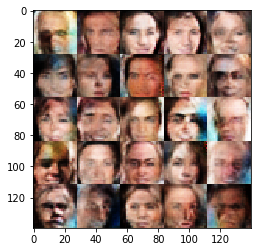

Epoch 1/1 - Batch 4410/6331:  Discriminator loss = 1.5538  Generator loss = 0.5349
Epoch 1/1 - Batch 4420/6331:  Discriminator loss = 0.7771  Generator loss = 3.1496
Epoch 1/1 - Batch 4430/6331:  Discriminator loss = 0.7513  Generator loss = 1.4748
Epoch 1/1 - Batch 4440/6331:  Discriminator loss = 0.4894  Generator loss = 2.8115
Epoch 1/1 - Batch 4450/6331:  Discriminator loss = 1.6982  Generator loss = 0.6547
Epoch 1/1 - Batch 4460/6331:  Discriminator loss = 0.4508  Generator loss = 3.0388
Epoch 1/1 - Batch 4470/6331:  Discriminator loss = 0.3802  Generator loss = 4.9189
Epoch 1/1 - Batch 4480/6331:  Discriminator loss = 0.3967  Generator loss = 4.0811
Epoch 1/1 - Batch 4490/6331:  Discriminator loss = 1.1353  Generator loss = 0.9544
Epoch 1/1 - Batch 4500/6331:  Discriminator loss = 0.3883  Generator loss = 5.2845


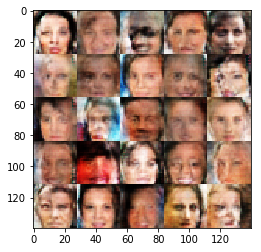

Epoch 1/1 - Batch 4510/6331:  Discriminator loss = 1.2331  Generator loss = 1.0211
Epoch 1/1 - Batch 4520/6331:  Discriminator loss = 0.3860  Generator loss = 5.0594
Epoch 1/1 - Batch 4530/6331:  Discriminator loss = 0.4210  Generator loss = 2.9612
Epoch 1/1 - Batch 4540/6331:  Discriminator loss = 0.5880  Generator loss = 2.2358
Epoch 1/1 - Batch 4550/6331:  Discriminator loss = 3.3230  Generator loss = 0.1167
Epoch 1/1 - Batch 4560/6331:  Discriminator loss = 0.3709  Generator loss = 5.0130
Epoch 1/1 - Batch 4570/6331:  Discriminator loss = 0.5576  Generator loss = 2.2630
Epoch 1/1 - Batch 4580/6331:  Discriminator loss = 0.4527  Generator loss = 4.2001
Epoch 1/1 - Batch 4590/6331:  Discriminator loss = 0.3770  Generator loss = 4.3416
Epoch 1/1 - Batch 4600/6331:  Discriminator loss = 0.9328  Generator loss = 1.1535


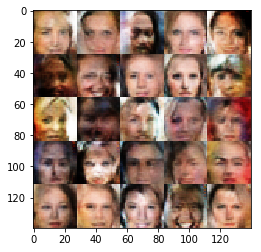

Epoch 1/1 - Batch 4610/6331:  Discriminator loss = 0.5046  Generator loss = 3.0681
Epoch 1/1 - Batch 4620/6331:  Discriminator loss = 0.5424  Generator loss = 4.0409
Epoch 1/1 - Batch 4630/6331:  Discriminator loss = 0.6097  Generator loss = 1.9779
Epoch 1/1 - Batch 4640/6331:  Discriminator loss = 0.4025  Generator loss = 5.4678
Epoch 1/1 - Batch 4650/6331:  Discriminator loss = 0.5474  Generator loss = 2.5362
Epoch 1/1 - Batch 4660/6331:  Discriminator loss = 0.4032  Generator loss = 3.8892
Epoch 1/1 - Batch 4670/6331:  Discriminator loss = 0.4397  Generator loss = 3.4235
Epoch 1/1 - Batch 4680/6331:  Discriminator loss = 1.2152  Generator loss = 4.5406
Epoch 1/1 - Batch 4690/6331:  Discriminator loss = 0.7713  Generator loss = 1.6759
Epoch 1/1 - Batch 4700/6331:  Discriminator loss = 0.5650  Generator loss = 2.4295


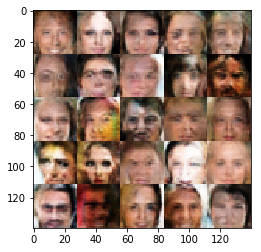

Epoch 1/1 - Batch 4710/6331:  Discriminator loss = 0.6718  Generator loss = 1.7920
Epoch 1/1 - Batch 4720/6331:  Discriminator loss = 0.5609  Generator loss = 1.8695
Epoch 1/1 - Batch 4730/6331:  Discriminator loss = 0.5602  Generator loss = 3.8199
Epoch 1/1 - Batch 4740/6331:  Discriminator loss = 0.8090  Generator loss = 2.4859
Epoch 1/1 - Batch 4750/6331:  Discriminator loss = 0.5193  Generator loss = 2.6547
Epoch 1/1 - Batch 4760/6331:  Discriminator loss = 0.6613  Generator loss = 1.7574
Epoch 1/1 - Batch 4770/6331:  Discriminator loss = 0.6792  Generator loss = 1.9311
Epoch 1/1 - Batch 4780/6331:  Discriminator loss = 0.8132  Generator loss = 1.3951
Epoch 1/1 - Batch 4790/6331:  Discriminator loss = 0.4040  Generator loss = 3.3634
Epoch 1/1 - Batch 4800/6331:  Discriminator loss = 0.5634  Generator loss = 2.0103


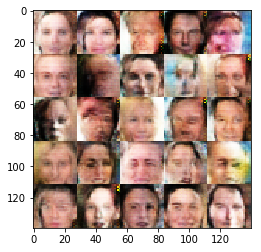

Epoch 1/1 - Batch 4810/6331:  Discriminator loss = 0.5345  Generator loss = 2.8476
Epoch 1/1 - Batch 4820/6331:  Discriminator loss = 0.3771  Generator loss = 5.1911
Epoch 1/1 - Batch 4830/6331:  Discriminator loss = 0.3672  Generator loss = 6.1627
Epoch 1/1 - Batch 4840/6331:  Discriminator loss = 0.3865  Generator loss = 4.2549
Epoch 1/1 - Batch 4850/6331:  Discriminator loss = 0.3787  Generator loss = 4.0240
Epoch 1/1 - Batch 4860/6331:  Discriminator loss = 0.7285  Generator loss = 1.7078
Epoch 1/1 - Batch 4870/6331:  Discriminator loss = 0.7316  Generator loss = 1.6528
Epoch 1/1 - Batch 4880/6331:  Discriminator loss = 0.6669  Generator loss = 2.4587
Epoch 1/1 - Batch 4890/6331:  Discriminator loss = 0.3726  Generator loss = 5.4287
Epoch 1/1 - Batch 4900/6331:  Discriminator loss = 0.4577  Generator loss = 2.9890


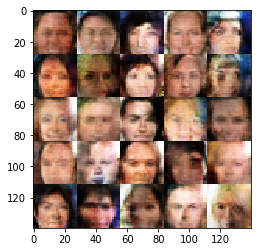

Epoch 1/1 - Batch 4910/6331:  Discriminator loss = 0.8549  Generator loss = 2.2343
Epoch 1/1 - Batch 4920/6331:  Discriminator loss = 0.5602  Generator loss = 2.2662
Epoch 1/1 - Batch 4930/6331:  Discriminator loss = 0.4520  Generator loss = 3.0222
Epoch 1/1 - Batch 4940/6331:  Discriminator loss = 0.3735  Generator loss = 5.9994
Epoch 1/1 - Batch 4950/6331:  Discriminator loss = 0.4043  Generator loss = 7.1186
Epoch 1/1 - Batch 4960/6331:  Discriminator loss = 1.0011  Generator loss = 1.7123
Epoch 1/1 - Batch 4970/6331:  Discriminator loss = 0.5096  Generator loss = 2.8258
Epoch 1/1 - Batch 4980/6331:  Discriminator loss = 0.5643  Generator loss = 2.1130
Epoch 1/1 - Batch 4990/6331:  Discriminator loss = 0.5723  Generator loss = 3.4702
Epoch 1/1 - Batch 5000/6331:  Discriminator loss = 0.3961  Generator loss = 4.4772


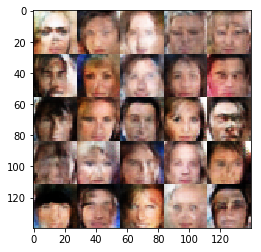

Epoch 1/1 - Batch 5010/6331:  Discriminator loss = 0.3483  Generator loss = 6.7861
Epoch 1/1 - Batch 5020/6331:  Discriminator loss = 0.9526  Generator loss = 1.1966
Epoch 1/1 - Batch 5030/6331:  Discriminator loss = 0.4023  Generator loss = 3.7275
Epoch 1/1 - Batch 5040/6331:  Discriminator loss = 0.4890  Generator loss = 2.4947
Epoch 1/1 - Batch 5050/6331:  Discriminator loss = 0.6039  Generator loss = 2.0526
Epoch 1/1 - Batch 5060/6331:  Discriminator loss = 1.4940  Generator loss = 4.6032
Epoch 1/1 - Batch 5070/6331:  Discriminator loss = 0.5312  Generator loss = 2.1878
Epoch 1/1 - Batch 5080/6331:  Discriminator loss = 0.3909  Generator loss = 4.7614
Epoch 1/1 - Batch 5090/6331:  Discriminator loss = 0.9532  Generator loss = 1.8908
Epoch 1/1 - Batch 5100/6331:  Discriminator loss = 0.5599  Generator loss = 2.2553


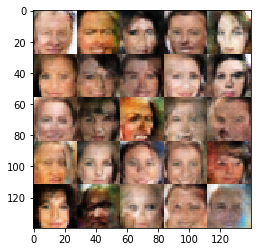

Epoch 1/1 - Batch 5110/6331:  Discriminator loss = 0.4028  Generator loss = 5.8697
Epoch 1/1 - Batch 5120/6331:  Discriminator loss = 0.9324  Generator loss = 2.3145
Epoch 1/1 - Batch 5130/6331:  Discriminator loss = 0.6539  Generator loss = 1.9358
Epoch 1/1 - Batch 5140/6331:  Discriminator loss = 1.1086  Generator loss = 0.9531
Epoch 1/1 - Batch 5150/6331:  Discriminator loss = 1.0856  Generator loss = 0.9845
Epoch 1/1 - Batch 5160/6331:  Discriminator loss = 0.5511  Generator loss = 2.7821
Epoch 1/1 - Batch 5170/6331:  Discriminator loss = 0.4100  Generator loss = 4.1208
Epoch 1/1 - Batch 5180/6331:  Discriminator loss = 0.4222  Generator loss = 3.5640
Epoch 1/1 - Batch 5190/6331:  Discriminator loss = 0.4926  Generator loss = 2.7692
Epoch 1/1 - Batch 5200/6331:  Discriminator loss = 0.5940  Generator loss = 2.5979


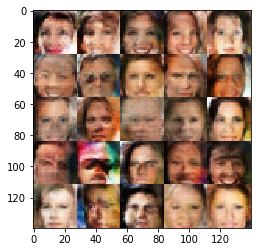

Epoch 1/1 - Batch 5210/6331:  Discriminator loss = 0.6858  Generator loss = 3.0841
Epoch 1/1 - Batch 5220/6331:  Discriminator loss = 0.4986  Generator loss = 2.5054
Epoch 1/1 - Batch 5230/6331:  Discriminator loss = 0.3822  Generator loss = 4.9002
Epoch 1/1 - Batch 5240/6331:  Discriminator loss = 1.3759  Generator loss = 0.9189
Epoch 1/1 - Batch 5250/6331:  Discriminator loss = 0.4965  Generator loss = 2.3685
Epoch 1/1 - Batch 5260/6331:  Discriminator loss = 0.4387  Generator loss = 2.9345
Epoch 1/1 - Batch 5270/6331:  Discriminator loss = 0.5827  Generator loss = 2.2528
Epoch 1/1 - Batch 5280/6331:  Discriminator loss = 2.4073  Generator loss = 0.2185
Epoch 1/1 - Batch 5290/6331:  Discriminator loss = 0.6090  Generator loss = 2.2073
Epoch 1/1 - Batch 5300/6331:  Discriminator loss = 0.4343  Generator loss = 3.5406


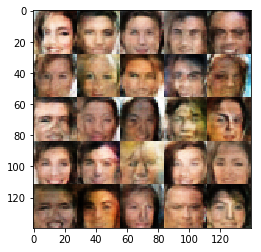

Epoch 1/1 - Batch 5310/6331:  Discriminator loss = 0.7129  Generator loss = 1.5039
Epoch 1/1 - Batch 5320/6331:  Discriminator loss = 1.3705  Generator loss = 0.6667
Epoch 1/1 - Batch 5330/6331:  Discriminator loss = 0.4740  Generator loss = 3.6716
Epoch 1/1 - Batch 5340/6331:  Discriminator loss = 0.5471  Generator loss = 3.7394
Epoch 1/1 - Batch 5350/6331:  Discriminator loss = 0.7091  Generator loss = 1.5506
Epoch 1/1 - Batch 5360/6331:  Discriminator loss = 0.5103  Generator loss = 2.5753
Epoch 1/1 - Batch 5370/6331:  Discriminator loss = 0.3819  Generator loss = 5.1113
Epoch 1/1 - Batch 5380/6331:  Discriminator loss = 0.3730  Generator loss = 4.2675
Epoch 1/1 - Batch 5390/6331:  Discriminator loss = 0.5554  Generator loss = 2.4295
Epoch 1/1 - Batch 5400/6331:  Discriminator loss = 0.5315  Generator loss = 2.1228


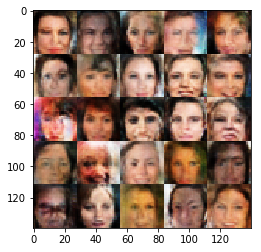

Epoch 1/1 - Batch 5410/6331:  Discriminator loss = 0.5940  Generator loss = 5.0423
Epoch 1/1 - Batch 5420/6331:  Discriminator loss = 0.5149  Generator loss = 2.2104
Epoch 1/1 - Batch 5430/6331:  Discriminator loss = 0.6962  Generator loss = 1.5014
Epoch 1/1 - Batch 5440/6331:  Discriminator loss = 0.6550  Generator loss = 1.7466
Epoch 1/1 - Batch 5450/6331:  Discriminator loss = 0.9648  Generator loss = 2.1392
Epoch 1/1 - Batch 5460/6331:  Discriminator loss = 1.1460  Generator loss = 0.9300
Epoch 1/1 - Batch 5470/6331:  Discriminator loss = 0.7240  Generator loss = 1.5666
Epoch 1/1 - Batch 5480/6331:  Discriminator loss = 0.5609  Generator loss = 2.0542
Epoch 1/1 - Batch 5490/6331:  Discriminator loss = 0.5592  Generator loss = 2.4596
Epoch 1/1 - Batch 5500/6331:  Discriminator loss = 0.4201  Generator loss = 3.5492


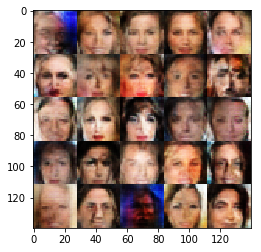

Epoch 1/1 - Batch 5510/6331:  Discriminator loss = 0.4069  Generator loss = 3.9397
Epoch 1/1 - Batch 5520/6331:  Discriminator loss = 0.6178  Generator loss = 2.7535
Epoch 1/1 - Batch 5530/6331:  Discriminator loss = 0.6184  Generator loss = 2.1144
Epoch 1/1 - Batch 5540/6331:  Discriminator loss = 0.4392  Generator loss = 3.3081
Epoch 1/1 - Batch 5550/6331:  Discriminator loss = 0.6864  Generator loss = 1.6874
Epoch 1/1 - Batch 5560/6331:  Discriminator loss = 0.5746  Generator loss = 3.4204
Epoch 1/1 - Batch 5570/6331:  Discriminator loss = 0.4649  Generator loss = 4.7258
Epoch 1/1 - Batch 5580/6331:  Discriminator loss = 0.4847  Generator loss = 6.0277
Epoch 1/1 - Batch 5590/6331:  Discriminator loss = 0.4606  Generator loss = 4.2204
Epoch 1/1 - Batch 5600/6331:  Discriminator loss = 0.4178  Generator loss = 4.0202


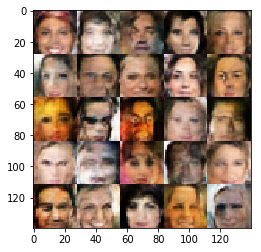

Epoch 1/1 - Batch 5610/6331:  Discriminator loss = 0.3720  Generator loss = 4.6441
Epoch 1/1 - Batch 5620/6331:  Discriminator loss = 0.6629  Generator loss = 1.8297
Epoch 1/1 - Batch 5630/6331:  Discriminator loss = 0.7199  Generator loss = 1.6670
Epoch 1/1 - Batch 5640/6331:  Discriminator loss = 0.3948  Generator loss = 4.4801
Epoch 1/1 - Batch 5650/6331:  Discriminator loss = 0.3608  Generator loss = 5.8457
Epoch 1/1 - Batch 5660/6331:  Discriminator loss = 0.5624  Generator loss = 3.1969
Epoch 1/1 - Batch 5670/6331:  Discriminator loss = 0.5616  Generator loss = 2.6106
Epoch 1/1 - Batch 5680/6331:  Discriminator loss = 0.7641  Generator loss = 1.4111
Epoch 1/1 - Batch 5690/6331:  Discriminator loss = 0.6145  Generator loss = 1.8949
Epoch 1/1 - Batch 5700/6331:  Discriminator loss = 0.4289  Generator loss = 3.3725


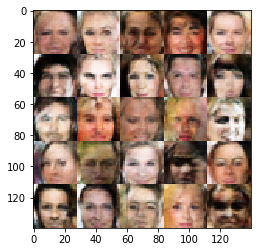

Epoch 1/1 - Batch 5710/6331:  Discriminator loss = 1.2902  Generator loss = 0.7490
Epoch 1/1 - Batch 5720/6331:  Discriminator loss = 0.4117  Generator loss = 4.0437
Epoch 1/1 - Batch 5730/6331:  Discriminator loss = 0.4670  Generator loss = 2.9878
Epoch 1/1 - Batch 5740/6331:  Discriminator loss = 0.9649  Generator loss = 1.1991
Epoch 1/1 - Batch 5750/6331:  Discriminator loss = 0.9154  Generator loss = 1.9932
Epoch 1/1 - Batch 5760/6331:  Discriminator loss = 0.4216  Generator loss = 3.6028
Epoch 1/1 - Batch 5770/6331:  Discriminator loss = 0.7304  Generator loss = 1.8201
Epoch 1/1 - Batch 5780/6331:  Discriminator loss = 1.6587  Generator loss = 0.8511
Epoch 1/1 - Batch 5790/6331:  Discriminator loss = 0.3736  Generator loss = 5.1860
Epoch 1/1 - Batch 5800/6331:  Discriminator loss = 0.4216  Generator loss = 3.1026


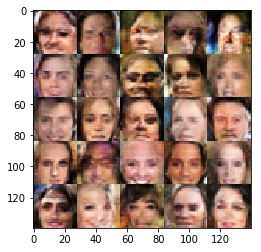

Epoch 1/1 - Batch 5810/6331:  Discriminator loss = 0.7354  Generator loss = 1.4711
Epoch 1/1 - Batch 5820/6331:  Discriminator loss = 0.6016  Generator loss = 2.0320
Epoch 1/1 - Batch 5830/6331:  Discriminator loss = 0.3789  Generator loss = 4.2946
Epoch 1/1 - Batch 5840/6331:  Discriminator loss = 0.5772  Generator loss = 2.2318
Epoch 1/1 - Batch 5850/6331:  Discriminator loss = 0.8352  Generator loss = 1.3018
Epoch 1/1 - Batch 5860/6331:  Discriminator loss = 0.4327  Generator loss = 3.5208
Epoch 1/1 - Batch 5870/6331:  Discriminator loss = 0.4212  Generator loss = 4.5005
Epoch 1/1 - Batch 5880/6331:  Discriminator loss = 0.7537  Generator loss = 1.9422
Epoch 1/1 - Batch 5890/6331:  Discriminator loss = 0.4418  Generator loss = 2.9262
Epoch 1/1 - Batch 5900/6331:  Discriminator loss = 0.4565  Generator loss = 3.0478


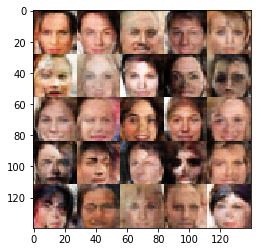

Epoch 1/1 - Batch 5910/6331:  Discriminator loss = 0.5031  Generator loss = 2.4972
Epoch 1/1 - Batch 5920/6331:  Discriminator loss = 0.6920  Generator loss = 1.5979
Epoch 1/1 - Batch 5930/6331:  Discriminator loss = 0.4581  Generator loss = 2.9686
Epoch 1/1 - Batch 5940/6331:  Discriminator loss = 0.5569  Generator loss = 2.0772
Epoch 1/1 - Batch 5950/6331:  Discriminator loss = 0.9789  Generator loss = 7.1255
Epoch 1/1 - Batch 5960/6331:  Discriminator loss = 0.4852  Generator loss = 4.0044
Epoch 1/1 - Batch 5970/6331:  Discriminator loss = 0.3963  Generator loss = 3.2756
Epoch 1/1 - Batch 5980/6331:  Discriminator loss = 0.4453  Generator loss = 3.0219
Epoch 1/1 - Batch 5990/6331:  Discriminator loss = 0.3831  Generator loss = 7.3122
Epoch 1/1 - Batch 6000/6331:  Discriminator loss = 0.6228  Generator loss = 1.9804


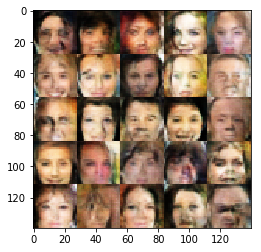

Epoch 1/1 - Batch 6010/6331:  Discriminator loss = 1.4441  Generator loss = 0.8310
Epoch 1/1 - Batch 6020/6331:  Discriminator loss = 0.5123  Generator loss = 3.3210
Epoch 1/1 - Batch 6030/6331:  Discriminator loss = 0.6514  Generator loss = 2.0251
Epoch 1/1 - Batch 6040/6331:  Discriminator loss = 3.3795  Generator loss = 0.0946
Epoch 1/1 - Batch 6050/6331:  Discriminator loss = 0.6316  Generator loss = 1.8502
Epoch 1/1 - Batch 6060/6331:  Discriminator loss = 0.8017  Generator loss = 1.4414
Epoch 1/1 - Batch 6070/6331:  Discriminator loss = 0.4364  Generator loss = 2.9791
Epoch 1/1 - Batch 6080/6331:  Discriminator loss = 0.4373  Generator loss = 4.2243
Epoch 1/1 - Batch 6090/6331:  Discriminator loss = 0.5772  Generator loss = 1.9210
Epoch 1/1 - Batch 6100/6331:  Discriminator loss = 0.7033  Generator loss = 1.6258


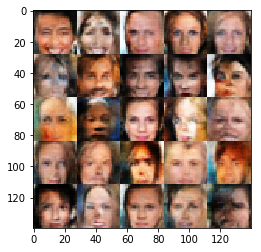

Epoch 1/1 - Batch 6110/6331:  Discriminator loss = 0.3765  Generator loss = 5.5883
Epoch 1/1 - Batch 6120/6331:  Discriminator loss = 0.7578  Generator loss = 1.8140
Epoch 1/1 - Batch 6130/6331:  Discriminator loss = 0.8722  Generator loss = 1.2392
Epoch 1/1 - Batch 6140/6331:  Discriminator loss = 0.5671  Generator loss = 2.1737
Epoch 1/1 - Batch 6150/6331:  Discriminator loss = 0.8570  Generator loss = 1.2097
Epoch 1/1 - Batch 6160/6331:  Discriminator loss = 0.6011  Generator loss = 2.3539
Epoch 1/1 - Batch 6170/6331:  Discriminator loss = 1.0242  Generator loss = 3.3773
Epoch 1/1 - Batch 6180/6331:  Discriminator loss = 0.4867  Generator loss = 3.1789
Epoch 1/1 - Batch 6190/6331:  Discriminator loss = 0.6394  Generator loss = 3.8394
Epoch 1/1 - Batch 6200/6331:  Discriminator loss = 0.4700  Generator loss = 4.0476


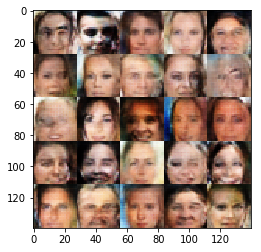

Epoch 1/1 - Batch 6210/6331:  Discriminator loss = 3.5136  Generator loss = 0.0734
Epoch 1/1 - Batch 6220/6331:  Discriminator loss = 0.5533  Generator loss = 2.2388
Epoch 1/1 - Batch 6230/6331:  Discriminator loss = 0.4146  Generator loss = 3.4838
Epoch 1/1 - Batch 6240/6331:  Discriminator loss = 0.4528  Generator loss = 3.0390
Epoch 1/1 - Batch 6250/6331:  Discriminator loss = 0.4618  Generator loss = 3.7868
Epoch 1/1 - Batch 6260/6331:  Discriminator loss = 0.6022  Generator loss = 1.9807
Epoch 1/1 - Batch 6270/6331:  Discriminator loss = 0.5035  Generator loss = 2.4760
Epoch 1/1 - Batch 6280/6331:  Discriminator loss = 0.5221  Generator loss = 2.5706
Epoch 1/1 - Batch 6290/6331:  Discriminator loss = 0.4147  Generator loss = 3.7623
Epoch 1/1 - Batch 6300/6331:  Discriminator loss = 0.8752  Generator loss = 1.4224


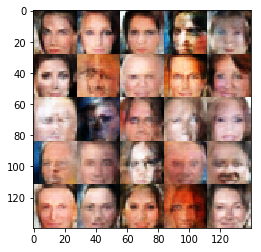

Epoch 1/1 - Batch 6310/6331:  Discriminator loss = 0.4403  Generator loss = 3.0213
Epoch 1/1 - Batch 6320/6331:  Discriminator loss = 0.5894  Generator loss = 2.0988
Epoch 1/1 - Batch 6330/6331:  Discriminator loss = 0.4110  Generator loss = 3.7304


In [63]:
batch_size = 32
z_dim = 100
learning_rate = .001
beta1 = .5
n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.